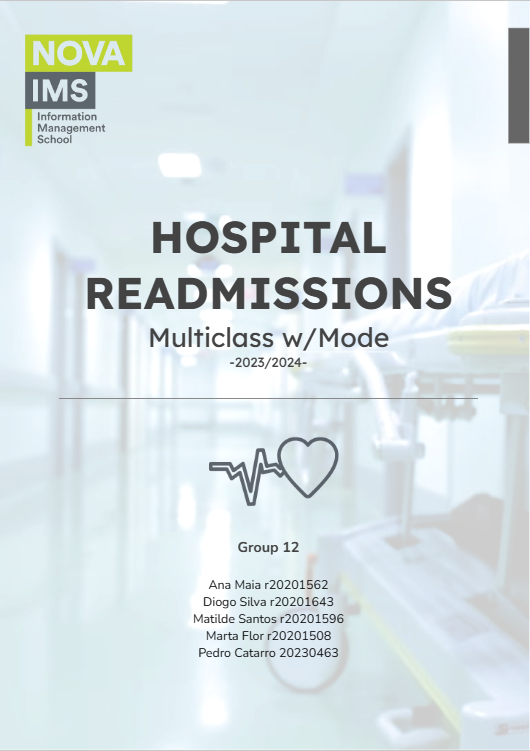
# **Disclaimer**

This notebook isn't neither of the ones we used for the conclusion of the project, it was an experimentation with mode as a way of treating the missing values present in the data, for the porpuse of obtaining better results.

## **Data Exploration**

In [4]:
# Import Libraries
!pip install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from imblearn.combine import SMOTEENN
import warnings

# Classifier imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [5]:
warnings.filterwarnings('ignore')

In [6]:
df_original = pd.read_csv('train.csv')

In [7]:
data = df_original.copy()

In [8]:
data.head(10)

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days
5,269878,USA,279288,Caucasian,Female,[50-60),?,?,0,0,...,250,244,3,NaN,Norm,No,No,[],No,>30 days
6,182051,USA,1566405,Caucasian,Female,[50-60),?,UN,0,0,...,250.02,493,9,NaN,>8,Ch,Yes,"['metformin', 'glimepiride']",No,No
7,964239,USA,60052095,Other,Male,[70-80),?,MC,0,0,...,287,276,9,NaN,NaN,Ch,Yes,"['nateglinide', 'glipizide', 'insulin']",No,No
8,418598,USA,85756257,Caucasian,Female,[50-60),?,MC,1,0,...,250.02,276,9,NaN,NaN,No,Yes,['insulin'],No,No
9,760130,USA,96104214,Caucasian,Female,[70-80),?,MC,0,0,...,398,745,9,NaN,NaN,No,Yes,['insulin'],No,>30 days


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   67682 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 71236 non-null  object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [10]:
# Check the unique values for each column
unique_values_per_column = {}

for column in data.columns:
    unique_values = pd.unique(data[column])
    unique_values_per_column[column] = unique_values

# Print the unique values for each column
for column, unique_values in unique_values_per_column.items():
    print(f"Column '{column}':")
    print(unique_values)
    print("\n")

Column 'encounter_id':
[533253 426224 634063 ... 332030 757560 459757]


Column 'country':
['USA']


Column 'patient_id':
[   70110 29775006 80729253 ... 65777877 24531381  4663818]


Column 'race':
['Caucasian' 'AfricanAmerican' 'Other' nan 'Hispanic' 'Asian' '?']


Column 'gender':
['Female' 'Male' 'Unknown/Invalid']


Column 'age':
['[70-80)' '[50-60)' '[60-70)' '[80-90)' nan '[40-50)' '[20-30)' '[30-40)'
 '[90-100)' '[10-20)' '[0-10)']


Column 'weight':
['?' '[50-75)' '[100-125)' '[75-100)' '[125-150)' '[25-50)' '>200'
 '[0-25)' '[150-175)' '[175-200)']


Column 'payer_code':
['?' 'MC' 'HM' 'UN' 'SP' 'SI' 'CM' 'DM' 'CP' 'MD' 'OG' 'BC' 'PO' 'WC' 'OT'
 'MP' 'CH' 'FR']


Column 'outpatient_visits_in_previous_year':
[ 0  1  2  6  5  3  4  9 36 11  7 16  8 10 12 15 13 20 27 14 35 22 24 21
 17 38 18 37 23 19 25 29 26 42 33 39 34 28]


Column 'emergency_visits_in_previous_year':
[ 0  1  6  2  5  4  9  3 10  7 11 12 13 22  8 14 19 25 20 37 29 28 18 16
 15 21 24 42 76 63]


Column 'inpatie

In [11]:
# Set the index to encounter_id
data.set_index('encounter_id', inplace = True)

In [12]:
data.shape

(71236, 30)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 533253 to 459757
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   67682 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 71236 non-null  object
 6   payer_code                             71236 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_s

In [14]:
# Summary Statistics for all columns, including categorical columns
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,71236,1,USA,71236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient_id,71236.0,NaN,NaN,NaN,54302279.330984,38795850.347332,135.0,23396510.25,45305631.0,87558374.25,189502619.0
race,67682,6,Caucasian,50693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,71236,3,Female,38228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,67679,10,[70-80),17359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,71236,10,?,68990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_code,71236,18,?,28201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0
emergency_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0
inpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.640154,1.267271,0.0,0.0,0.0,1.0,21.0


In [15]:
# Check whether we have an unbalanced dataset
data['readmitted_binary'].value_counts()/len(data) * 100

No     88.839912
Yes    11.160088
Name: readmitted_binary, dtype: float64

In [16]:
data['readmitted_multiclass'].value_counts()/len(data) * 100

No          53.912348
>30 days    34.927565
<30 days    11.160088
Name: readmitted_multiclass, dtype: float64

In [17]:
data.drop("readmitted_binary", axis=1, inplace=True)

In [18]:
# Check if there are Duplicates
data[data.duplicated(keep=False)]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,


In [19]:
# Define metric, non-metric features, and target features
metric_features = ["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year", "average_pulse_bpm" ,"length_of_stay_in_hospital", "number_lab_tests", "non_lab_procedures", "number_of_medications", "number_diagnoses" ]

columns_to_drop = metric_features + ['readmitted_multiclass']
non_metric_features = data.drop(columns=columns_to_drop).columns.to_list()

target = ['readmitted_multiclass']

In [20]:
non_metric_features.remove('patient_id')

In [21]:
non_metric_features

['country',
 'race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'admission_type',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'medication']

In [22]:
metric_features

['outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses']

## **Incoherence Checking**

In [23]:
data['readmitted_multiclass'].value_counts()

No          38405
>30 days    24881
<30 days     7950
Name: readmitted_multiclass, dtype: int64

In [24]:
# Check how many duplicate diagnosis exists in the dataset
len(data[(data['primary_diagnosis'] == data['secondary_diagnosis']) |
    (data['primary_diagnosis'] == data['additional_diagnosis']) |
    (data['secondary_diagnosis'] == data['additional_diagnosis'])])

3997

In [25]:
data.loc[(data['primary_diagnosis'] == data['secondary_diagnosis']) |
         (data['primary_diagnosis'] == data['additional_diagnosis']) |
         (data['secondary_diagnosis'] == data['additional_diagnosis']),
         ['secondary_diagnosis', 'additional_diagnosis']] = 'No diagnoses'

In [26]:
# Remove the initial space in the admission_source classes
data['admission_source'] = data['admission_source'].str.replace('^ ', '', regex=True)

In [27]:
# Remove Expired
expired = data[data['discharge_disposition'].fillna(' ').str.contains('expired', case = False)]
data.drop(expired.index, axis = 0, inplace = True)

## **Split the dataset (Train and Validation)**


In [28]:
data_le = data.copy()
label_encoder = LabelEncoder()
data_le['readmitted_multiclass'] = label_encoder.fit_transform(data_le['readmitted_multiclass'])
data_le['readmitted_multiclass'].unique()

array([1, 2, 0])

In [29]:
data['readmitted_multiclass'] = data_le['readmitted_multiclass']
data.head(5)

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,...,515,276,466,8,NaN,NaN,No,No,[],1
426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,...,38,785,162,9,NaN,NaN,No,Yes,['insulin'],2
634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,...,534,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",2
890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,...,569,562,455,5,NaN,NaN,No,No,[],2
654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,...,715,599,428,9,NaN,NaN,No,No,[],1


In [30]:
data_split = data.copy()

In [31]:
X = data_split.drop('readmitted_multiclass', axis = 1)
target_multiclass = data_split['readmitted_multiclass']

In [32]:
# Split the data into train and validation
# Since we have an unbalanced dataset, we decided to perform the stratified splitting

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  target_multiclass,
                                                  test_size = 0.3,
                                                  random_state = 0,
                                                  stratify = target_multiclass,
                                                  shuffle = True)

In [33]:
# Convert the target variable to dummy (Train)
y_train.replace({'Yes': 1, 'No': 0}, inplace = True)
y_train.unique()

array([2, 1, 0])

In [34]:
# Convert the target variable to dummy (Validation)
y_val.replace({'Yes': 1, 'No': 0}, inplace = True)
y_val.unique()

array([2, 1, 0])

In [35]:
y_train

encounter_id
160076    2
170876    1
644304    2
487584    1
296497    2
         ..
465401    1
961904    2
995085    0
960973    1
920405    1
Name: readmitted_multiclass, Length: 49065, dtype: int64

In [36]:
y_val

encounter_id
734459    2
781292    1
448353    0
693100    2
475731    1
         ..
528547    2
940543    1
198730    1
594310    1
814267    2
Name: readmitted_multiclass, Length: 21029, dtype: int64

## **Treating Outliers**

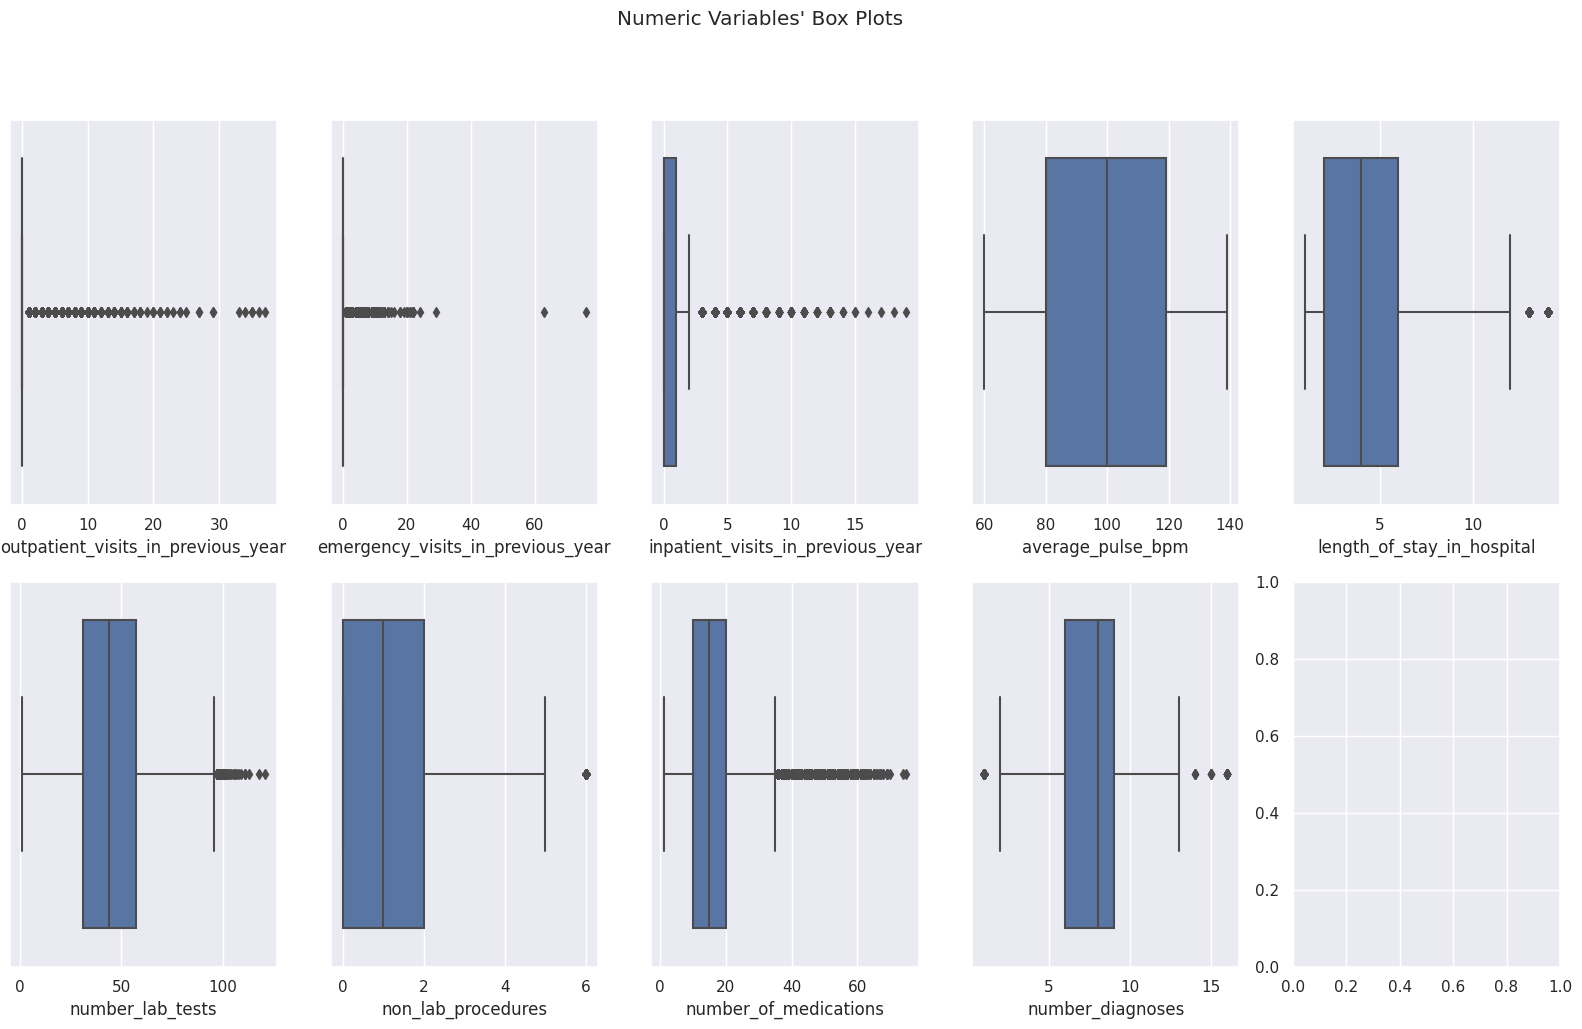

In [37]:
# All Numeric Variables' Box Plots in one figure
sns.set()
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x = X_train[feat], ax = ax)

# Layout
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

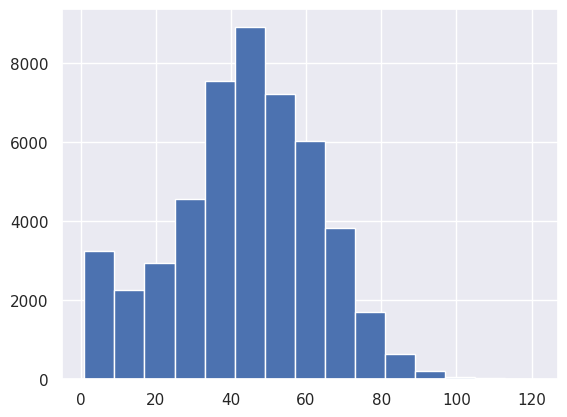

In [38]:
plt.hist(X_train["number_lab_tests"], bins=15)
plt.show()

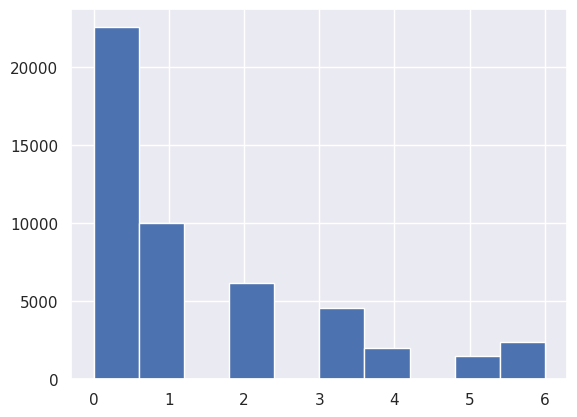

In [39]:
plt.hist(X_train["non_lab_procedures"], bins=10)
plt.show()

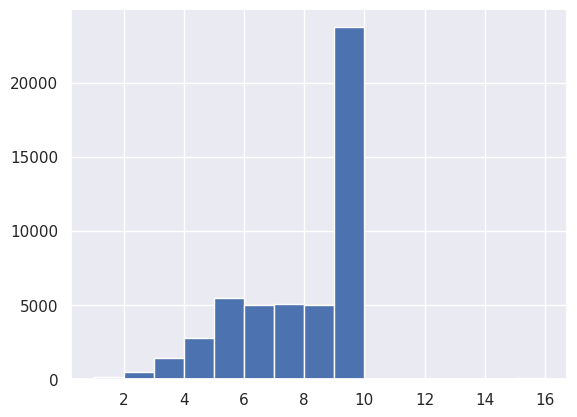

In [40]:
plt.hist(X_train["number_diagnoses"], bins=15)
plt.show()

In [41]:
len(X_train[X_train["outpatient_visits_in_previous_year"] > 30])

6

In [42]:
len(X_train[X_train["emergency_visits_in_previous_year"] > 30])

2

In [43]:
len(X_train[X_train["inpatient_visits_in_previous_year"] > 17])

2

In [44]:
len(X_train[X_train["length_of_stay_in_hospital"] > 13])

487

In [45]:
len(X_train[X_train["number_lab_tests"] > 100])

24

In [46]:
len(X_train[X_train["non_lab_procedures"] > 5])

2375

In [47]:
len(X_train[X_train["number_of_medications"] > 65])

17

In [48]:
len(X_train[X_train["number_of_medications"] > 38])

813

In [49]:
len(X_train[(X_train["number_diagnoses"] < 2) | (X_train["number_diagnoses"] > 13)])

147

In [50]:
filters1 = (
    (X_train["outpatient_visits_in_previous_year"] <= 30)
    &
    (X_train["emergency_visits_in_previous_year"] <= 30)
    &
    (X_train["inpatient_visits_in_previous_year"] <=  17)
    #&
   #(X_train["length_of_stay_in_hospital"] <= 13)
    &
    (X_train["number_lab_tests"] <= 110)
    &
    (X_train["number_of_medications"] <= 65)
    &
    (X_train["number_diagnoses"] >= 2)
    &
    (X_train["number_diagnoses"] <= 13))

df_1 = X_train[filters1]

In [51]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / X_train.shape[0], 4))

Percentage of data kept after removing outliers: 0.9964


In [52]:
# Outlier removal using only the IQR method

q25 = X_train[metric_features].quantile(.25)
q75 = X_train[metric_features].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(X_train[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = X_train[filters2.values]

print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / X_train.shape[0], 4))

Percentage of data kept after removing outliers: 0.6628


In [53]:
# Combine both methods (Manual and Boxplot)
df_3 = X_train[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / X_train.shape[0], 4))

Percentage of data kept after removing outliers: 0.9964


In [54]:
#Update X_train
X_train = df_3.copy()

In [55]:
# Keep the same rows of X_train in y_train
y_train = y_train.loc[X_train.index]

In [56]:
y_train.index == X_train.index

array([ True,  True,  True, ...,  True,  True,  True])

## **Missing Values**

In [57]:
X_train.isna().sum()

country                                      0
patient_id                                   0
race                                      2437
gender                                       0
age                                       2434
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            2572
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     1818
admission_source                          3181
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [58]:
# Replace unknowns for nan
X_train = X_train.replace(["?", "Unknown/Invalid", "Not Available", "Not Mapped", " " , '[]' ],np.nan)

# Repeat for Validation
X_val = X_val.replace(["?", "Unknown/Invalid", "Not Available", "Not Mapped", " ", '[]' ],np.nan)

In [59]:
#Verify
is_empty_list_present = '[]' in X_train['medication'].unique()

In [60]:
is_empty_list_present

False

In [61]:
X_train.isna().sum()

country                                      0
patient_id                                   0
race                                      3449
gender                                       2
age                                       2434
weight                                   47353
payer_code                               19288
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            4937
medical_specialty                        23984
average_pulse_bpm                            0
discharge_disposition                     2286
admission_source                          3314
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           13
secondary_diagnosis                         31
additional_di

In [62]:
# The non-code values in 'payer_code' ("?") are due to people that don´t have insurance
# Hence, we imputed them with the label 'Not Insurance'.

X_train["payer_code"].replace(np.nan, "No Insurance", inplace = True)

In [63]:
#Repeat for validation

X_val["payer_code"].replace(np.nan, "No Insurance", inplace = True)

In [64]:
# The missing values in 'glucose_test_result' and 'a1c_test_result' are due to patients not taking these tests.
# Hence, we imputed them with the label 'Not Taken'.

X_train["glucose_test_result"].replace(np.nan, "Not Taken", inplace = True)
X_train["a1c_test_result"].replace(np.nan, "Not Taken",  inplace = True)

In [65]:
#Repeat for VAL

X_val["glucose_test_result"].replace(np.nan, "Not Taken", inplace = True)
X_val["a1c_test_result"].replace(np.nan, "Not Taken",  inplace = True)

In [66]:
X_train['admission_source'].replace(np.nan, "Not Mapped", inplace = True)

In [67]:
#REPEAT FOR VAL
X_val['admission_source'].replace(np.nan, "Not Mapped", inplace = True)

In [68]:
X_train['medication'].replace(np.nan, 'No Medication', inplace = True)

In [69]:
#REPEAT FOR VAL
X_val['medication'].replace(np.nan, 'No Medication', inplace = True)

In [70]:
X_train['secondary_diagnosis'].replace(np.nan, "Not Taken", inplace = True)
X_train['additional_diagnosis'].replace(np.nan, "Not Taken", inplace = True)

In [71]:
#REPEAT FOR VAL
X_val['secondary_diagnosis'].replace(np.nan, "Not Taken", inplace = True)
X_val['additional_diagnosis'].replace(np.nan, "Not Taken", inplace = True)

In [72]:
# Train Dataset Missing values %
X_train.isna().sum() / len(data) * 100

country                                   0.000000
patient_id                                0.000000
race                                      4.920535
gender                                    0.002853
age                                       3.472480
weight                                   67.556424
payer_code                                0.000000
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                            7.043399
medical_specialty                        34.216909
average_pulse_bpm                         0.000000
discharge_disposition                     3.261335
admission_source                          0.000000
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications                     0.000000
primary_diagnosis              

In [73]:
# Validation Dataset Missing values %
X_val.isna().sum() / len(data) * 100

country                                   0.000000
patient_id                                0.000000
race                                      2.181356
gender                                    0.001427
age                                       1.522242
weight                                   29.035295
payer_code                                0.000000
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                            3.120096
medical_specialty                        14.681713
average_pulse_bpm                         0.000000
discharge_disposition                     1.392416
admission_source                          0.000000
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications                     0.000000
primary_diagnosis              

# **Missing Values Treatment**
1. weight: Delete (96% mv)
2. race: Input mv as 'Not Provided' (most observations are classified as ' Caucasian' so it will bias the results)
3. age, admission_type, discharge_disposition, admission_source, primary_diagnosis; secondary_diagnosis; additional_diagnosis; medical specialty: **Apply Mode**
4. glucose_test_result, a1c_test_result: Impute mv as Note Taken (meaning these observations did not toke the tests)





In [74]:
len(X_train.columns)

28

**Mode**

In [75]:
train_mv = X_train.copy()
val_mv = X_val.copy()

In [76]:
len(train_mv.columns)

28

In [77]:
# Drop columns that have really high percentage of missing values (> 50%)
train_mv.drop(["weight"], axis=1, inplace=True)
non_metric_features.remove("weight")

# REPEAT FOR VALIDATION
val_mv.drop(["weight"], axis=1, inplace=True)

In [78]:
features_to_impute = ['race', 'gender','age', 'admission_type', 'discharge_disposition',
                      'primary_diagnosis', "medical_specialty"]

In [79]:
modes = train_mv[features_to_impute].mode().loc[0]
modes

race                              Caucasian
gender                               Female
age                                 [70-80)
admission_type                    Emergency
discharge_disposition    Discharged to home
primary_diagnosis                       428
medical_specialty          InternalMedicine
Name: 0, dtype: object

In [80]:
# Replace the missing values of the categorial features with the mode
train_mv.fillna(modes, inplace=True)

In [81]:
# Repeat for validation
val_mv.fillna(modes, inplace=True)

In [82]:
# Check the variables summary statistics AFTER IMPUTATION
train_mv[features_to_impute].describe().T.round(3)

,count,unique,top,freq
race,48886,5,Caucasian,38119
gender,48886,2,Female,26248
age,48886,10,[70-80),14352
admission_type,48886,5,Emergency,30746
discharge_disposition,48886,21,Discharged to home,31665
primary_diagnosis,48886,657,428,3263
medical_specialty,48886,67,InternalMedicine,30981


In [83]:
train_mv.isna().sum()

country                                  0
patient_id                               0
race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_re

In [84]:
val_mv.isna().sum()

country                                  0
patient_id                               0
race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_re

In [85]:
X_train = train_mv.copy()
X_val = val_mv.copy()

# **Feature Engenniring**

**total_visits_in_previous_year**: Number of outpatient, emergency, and inpatient visits the patient made to the hospital in the year preceding the encounter.

In [86]:
X_train['total_visits_in_previous_year'] = X_train['outpatient_visits_in_previous_year'] + X_train['emergency_visits_in_previous_year'] + X_train['inpatient_visits_in_previous_year']

In [87]:
X_val['total_visits_in_previous_year'] = X_val['outpatient_visits_in_previous_year'] + X_val['emergency_visits_in_previous_year'] + X_val['inpatient_visits_in_previous_year']

In [88]:
X_train['total_encounters'] = X_train.groupby('patient_id')['patient_id'].transform('count')
metric_features.append('total_encounters')
X_train.drop(["patient_id"], axis=1, inplace=True)

In [89]:
X_val['total_encounters'] = X_val.groupby('patient_id')['patient_id'].transform('count')
X_val.drop(["patient_id"], axis=1, inplace=True)

**primary_diagnoses_categories, secondary_diagnoses_categories, additional_diagnoses_categories**: Variables represent the ICD9 Codes grouped in categories.

In [90]:
# Based on the ICD9 Codes, we will create a variable that groups the codes into categories.
def categorize_icd9(icd9_code):

    icd9_code = str(icd9_code)

    if '001' <= icd9_code <= '139':   return 'Infectious and Parasitic Diseases'

    elif '140' <= icd9_code <= '239': return 'Neoplasms'

    elif '240' <= icd9_code <= '279': return 'Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disorders'

    elif '280' <= icd9_code <= '289': return 'Diseases of the Blood and Blood-Forming Organs'

    elif '290' <= icd9_code <= '319': return 'Mental Disorders'

    elif '320' <= icd9_code <= '389': return 'Diseases of the Nervous System and Sense Organs'

    elif '390' <= icd9_code <= '459': return 'Diseases of the Circulatory System'

    elif '460' <= icd9_code <= '519': return 'Diseases of the Respiratory System'

    elif '520' <= icd9_code <= '579': return 'Diseases of the Digestive System'

    elif '580' <= icd9_code <= '629': return 'Diseases of the Genitourinary System'

    elif '630' <= icd9_code <= '679': return 'Complications of Pregnancy, Childbirth, and the Puerperium'

    elif '680' <= icd9_code <= '709': return 'Diseases of the Skin and Subcutaneous Tissue'

    elif '710' <= icd9_code <= '739': return 'Diseases of the Musculoskeletal System and Connective Tissue'

    elif '740' <= icd9_code <= '759': return 'Congenital Anomalies'

    elif '760' <= icd9_code <= '779': return 'Certain Conditions Originating in the Perinatal Period'

    elif '780' <= icd9_code <= '799': return 'Symptoms, Signs, and Ill-Defined Conditions'

    elif '800' <= icd9_code <= '999': return 'Injury and Poisoning'

    elif icd9_code.startswith(('E', 'V')):  return 'External Causes of Injury and Supplemental Classification'

    else:return 'Uncategorized'

In [91]:
X_train['primary_diagnoses_categories'] = (X_train['primary_diagnosis'].apply(categorize_icd9))
X_train['secondary_diagnoses_categories'] = (X_train['secondary_diagnosis'].apply(categorize_icd9))
X_train['additional_diagnoses_categories'] = (X_train['additional_diagnosis'].apply(categorize_icd9))

In [92]:
X_train['primary_diagnoses_categories'].unique()

array(['Diseases of the Circulatory System',
       'Diseases of the Respiratory System',
       'Diseases of the Digestive System',
       'Diseases of the Genitourinary System',
       'Symptoms, Signs, and Ill-Defined Conditions', 'Neoplasms',
       'Complications of Pregnancy, Childbirth, and the Puerperium',
       'Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disorders',
       'Mental Disorders',
       'Diseases of the Musculoskeletal System and Connective Tissue',
       'External Causes of Injury and Supplemental Classification',
       'Diseases of the Skin and Subcutaneous Tissue', 'Uncategorized',
       'Injury and Poisoning',
       'Diseases of the Blood and Blood-Forming Organs',
       'Diseases of the Nervous System and Sense Organs',
       'Infectious and Parasitic Diseases', 'Congenital Anomalies'],
      dtype=object)

In [93]:
# Repeat for Validation
X_val['primary_diagnoses_categories'] = (X_val['primary_diagnosis'].apply(categorize_icd9))
X_val['secondary_diagnoses_categories'] = (X_val['secondary_diagnosis'].apply(categorize_icd9))
X_val['additional_diagnoses_categories'] = (X_val['additional_diagnosis'].apply(categorize_icd9))

**insulation_medication**: Defines if the patient takes insuline.

In [94]:
print('Encounters where patients took insulin and metformin:',
     ((X_train['medication'].astype(str).str.contains('insulin'))
     & X_train['medication'].astype(str).str.contains('metformin')).sum(),

     '\nEncounters where patients took only insulin:',
     ((X_train['medication'].astype(str).str.contains('insulin'))
     & ~X_train['medication'].astype(str).str.contains('metformin')).sum(),

     '\nEncounters where patients took only metformin:',
     (~X_train['medication'].astype(str).str.contains('insulin')
     & X_train['medication'].astype(str).str.contains('metformin')).sum())

Encounters where patients took insulin and metformin: 5028 
Encounters where patients took only insulin: 21069 
Encounters where patients took only metformin: 4985


**type2**: Defines if the patient has type 2 diabetes.

In [95]:
# Insulin is used in the treatment and management of diabetes mellitus type-1 and sometimes diabetes mellitus type-2
# Metformin is a medicine used to treat type 2 diabetes and gestational diabetes

# Create a new column with a default value
X_train['type2'] = np.nan

X_train.loc[ ~X_train['medication'].astype(str).str.contains('metformin'), 'type2'] = 0

X_train.loc[ X_train['medication'].astype(str).str.contains('metformin'), 'type2'] = 1

In [96]:
# Insulin is used in the treatment and management of diabetes mellitus type-1 and sometimes diabetes mellitus type-2
# Metformin is a medicine used to treat type 2 diabetes and gestational diabetes

# Create a new column with a default value
X_val['type2'] = np.nan

X_val.loc[ ~X_val['medication'].astype(str).str.contains('metformin'), 'type2'] = 0

X_val.loc[ X_val['medication'].astype(str).str.contains('metformin'), 'type2'] = 1

**diagnosed_diabetes**: Column take states whether the patients was diagnosed with diabetes.

Classes: 0 - No Diabetes | 1 - Diabetes

In [97]:
print(
    'Diabetes in Primary Diagnosis:', len(X_train.loc[X_train['primary_diagnosis'].astype(str).str.contains('250')]),
    '\nDiabetes in Secondary Diagnosis:', len(X_train.loc[X_train['secondary_diagnosis'].astype(str).str.contains('250')]),
    '\nDiabetes in Additional Diagnosis:', len(X_train.loc[X_train['additional_diagnosis'].astype(str).str.contains('250')])
)

Diabetes in Primary Diagnosis: 4123 
Diabetes in Secondary Diagnosis: 6151 
Diabetes in Additional Diagnosis: 8099


In [98]:
print(
'Only the first diagnosis:',
(X_train['primary_diagnosis'].astype(str).str.contains('250')
& ~X_train['secondary_diagnosis'].astype(str).str.contains('250')
& ~X_train['additional_diagnosis'].astype(str).str.contains('250')).sum(),

'\nFirst 2 diagnosis have diabetes:',
(X_train['primary_diagnosis'].astype(str).str.contains('250')
& X_train['secondary_diagnosis'].astype(str).str.contains('250')
& ~X_train['additional_diagnosis'].astype(str).str.contains('250')).sum(),

'\nAll 3 diagnosis have diabetes:',
(X_train['primary_diagnosis'].astype(str).str.contains('250')
& X_train['secondary_diagnosis'].astype(str).str.contains('250')
& X_train['additional_diagnosis'].astype(str).str.contains('250')).sum())

Only the first diagnosis: 3967 
First 2 diagnosis have diabetes: 40 
All 3 diagnosis have diabetes: 4


In [99]:
X_train['diagnosed_diabetes'] = np.nan

# If the patient was diagnosed with diabetes in any diagnosis (1: 'Yes')
X_train.loc[  X_train['primary_diagnosis'].astype(str).str.contains('250')
                  | X_train['secondary_diagnosis'].astype(str).str.contains('250')
                  | X_train['additional_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 1

# If the patient was not diagnosed with diabetes in any diagnosis (0: 'No')
X_train.loc[~X_train['primary_diagnosis'].astype(str).str.contains('250')
                  & ~X_train['secondary_diagnosis'].astype(str).str.contains('250')
                  & ~X_train['secondary_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 0

In [100]:
(X_train['diagnosed_diabetes'].value_counts() / len(X_train) * 100).round(2)

0.0    79.07
1.0    20.93
Name: diagnosed_diabetes, dtype: float64

In [101]:
X_train.head(5)

,country,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,...,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,total_visits_in_previous_year,total_encounters,primary_diagnoses_categories,secondary_diagnoses_categories,additional_diagnoses_categories,type2,diagnosed_diabetes
encounter_id,,,,,,,,,,,,,,,,,,,,,
160076,USA,Caucasian,Male,[60-70),No Insurance,0,0,0,Urgent,Family/GeneralPractice,...,Ch,Yes,"['pioglitazone', 'insulin']",0,1,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System,0.0,0.0
170876,USA,Caucasian,Female,[60-70),CP,3,0,0,Emergency,InternalMedicine,...,No,No,No Medication,3,1,Diseases of the Circulatory System,Diseases of the Genitourinary System,Diseases of the Respiratory System,0.0,0.0
644304,USA,Caucasian,Female,[90-100),MC,0,0,0,Emergency,InternalMedicine,...,Ch,Yes,"['glyburide', 'insulin']",0,1,Diseases of the Respiratory System,Diseases of the Respiratory System,"Endocrine, Nutritional, and Metabolic Diseases...",0.0,0.0
487584,USA,Caucasian,Female,[50-60),MC,0,0,0,Emergency,InternalMedicine,...,No,Yes,['insulin'],0,3,Diseases of the Respiratory System,Diseases of the Genitourinary System,Infectious and Parasitic Diseases,0.0,0.0
296497,USA,Caucasian,Female,[90-100),No Insurance,0,0,0,Emergency,InternalMedicine,...,No,No,No Medication,0,1,Diseases of the Digestive System,"Endocrine, Nutritional, and Metabolic Diseases...",Diseases of the Circulatory System,0.0,0.0


In [102]:
# REPEAT FOR VALIDATION
X_val['diagnosed_diabetes'] = np.nan

# If the patient was diagnosed with diabetes in any diagnosis
X_val.loc[X_val['primary_diagnosis'].astype(str).str.contains('250')
                  | X_val['secondary_diagnosis'].astype(str).str.contains('250')
                  | X_val['additional_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 1

# If the patient was not diagnosed with diabetes in any diagnosis
X_val.loc[~X_val['primary_diagnosis'].astype(str).str.contains('250')
                  & ~X_val['secondary_diagnosis'].astype(str).str.contains('250')
                  & ~X_val['secondary_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 0

In [103]:
X_val.head(5)

,country,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,...,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,total_visits_in_previous_year,total_encounters,primary_diagnoses_categories,secondary_diagnoses_categories,additional_diagnoses_categories,type2,diagnosed_diabetes
encounter_id,,,,,,,,,,,,,,,,,,,,,
734459,USA,Caucasian,Male,[60-70),MC,0,0,0,Emergency,Emergency/Trauma,...,No,Yes,['insulin'],0,1,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System,0.0,0.0
781292,USA,AfricanAmerican,Male,[60-70),MC,0,0,1,Emergency,InternalMedicine,...,No,Yes,['insulin'],1,2,Diseases of the Digestive System,Diseases of the Genitourinary System,"Symptoms, Signs, and Ill-Defined Conditions",0.0,0.0
448353,USA,Caucasian,Female,[90-100),MC,0,0,4,Emergency,InternalMedicine,...,No,No,No Medication,4,3,Diseases of the Digestive System,"Endocrine, Nutritional, and Metabolic Diseases...",Diseases of the Digestive System,0.0,1.0
693100,USA,Caucasian,Male,[40-50),HM,2,0,0,Emergency,InternalMedicine,...,No,Yes,['insulin'],2,1,"Endocrine, Nutritional, and Metabolic Diseases...","Symptoms, Signs, and Ill-Defined Conditions",Injury and Poisoning,0.0,1.0
475731,USA,Caucasian,Female,[70-80),MC,0,1,4,Emergency,InternalMedicine,...,Ch,Yes,['insulin'],5,2,Diseases of the Nervous System and Sense Organs,Diseases of the Respiratory System,"Endocrine, Nutritional, and Metabolic Diseases...",0.0,0.0


**race**: Group 'Asian', 'Hispanic', and 'Other.

In [104]:
# Replace values in 'race' and create a new column 'Caucasian'
X_train['race'] = X_train['race'].replace({'Hispanic': 'Other','Asian': 'Other'})

In [105]:
# Repeat for validadion
X_val['race'] = X_val['race'].replace({'Hispanic': 'Other', 'Asian': 'Other'})

<Axes: xlabel='race', ylabel='Count'>

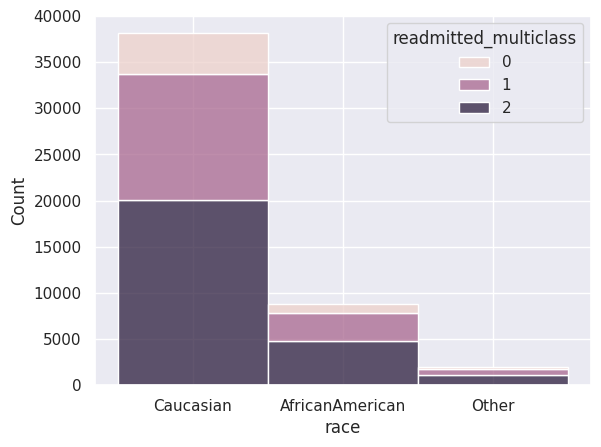

In [106]:
sns.histplot(data = X_train, x = "race", hue = y_train, multiple = "stack")

**Female**: Binary Variable that indicates if the patient is female (1) or not (0)

In [107]:
X_train['Female'] = X_train['gender'].replace({'Female': 1,'Male': 0})
X_train['Female'].value_counts()

1    26248
0    22638
Name: Female, dtype: int64

In [108]:
X_val['Female'] = X_val['gender'].replace({'Female': 1, 'Male': 0})
X_val['Female'].value_counts()

1    11335
0     9694
Name: Female, dtype: int64

In [109]:
X_train.drop('gender', axis = 1, inplace = True)
X_val.drop('gender', axis = 1, inplace = True)

In [110]:
non_metric_features.remove('gender')

**age**: Transform variable in numeric by doing the mean between the 2 interval values.

<Axes: xlabel='age', ylabel='Count'>

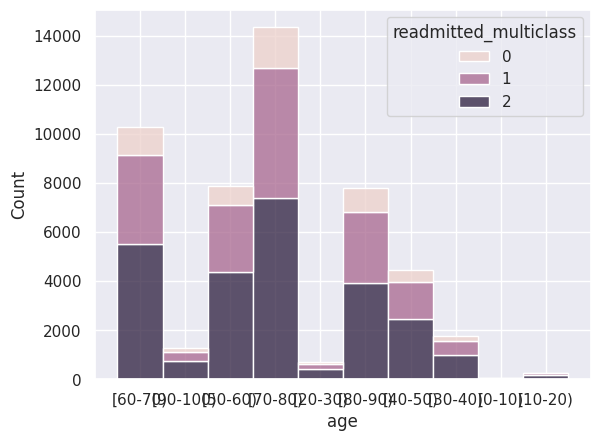

In [111]:
sns.histplot(data = X_train, x = "age", hue = y_train, multiple = "stack")

In [112]:
X_train['age'] = X_train['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
                                        '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95})
X_train['age'].value_counts()

75    14352
65    10292
55     7897
85     7812
45     4451
35     1750
95     1287
25      723
15      273
5        49
Name: age, dtype: int64

In [113]:
X_val['age'] = X_val['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
                                    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95})

**payer_code**: Decrease the number of categories (Group classess that represent less than 5% of the dataset)

<Axes: xlabel='payer_code', ylabel='Count'>

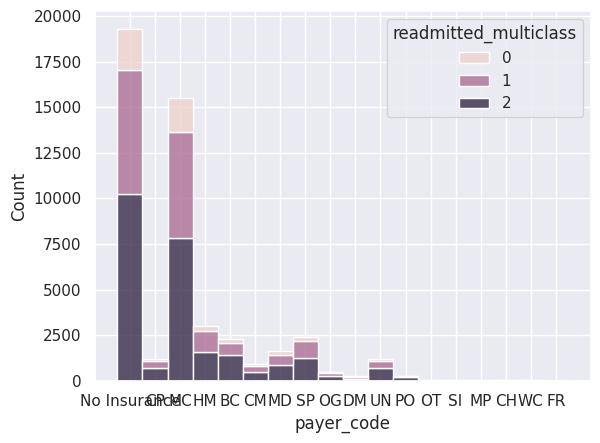

In [114]:
sns.histplot(data = X_train, x = "payer_code", hue = y_train, multiple = "stack")
# The categories 'No insurance' and 'MC' are the most relevant ones

In [115]:
X_train['payer_code'].value_counts(normalize = True)

No Insurance    0.394551
MC              0.317555
HM              0.061551
SP              0.049748
BC              0.047355
MD              0.033957
CP              0.025099
UN              0.024731
CM              0.019024
OG              0.009880
PO              0.006055
DM              0.005462
WC              0.001534
CH              0.001330
OT              0.000798
SI              0.000695
MP              0.000655
FR              0.000020
Name: payer_code, dtype: float64

In [116]:
X_train['payer_code'] = X_train['payer_code'].replace({'MP': 'Other','FR': 'Other','SI': 'Other','CH': 'Other',
                                                   'PO': 'Other','OT': 'Other','WC': 'Other','DM': 'Other',
                                                   'OG': 'Other','CM': 'Other', 'UN': 'Other', 'CP': 'Other', 'MD': 'Other',
                                                   'BC': 'Other'})
X_train['payer_code'].value_counts()

No Insurance    19288
MC              15524
Other            8633
HM               3009
SP               2432
Name: payer_code, dtype: int64

In [117]:
X_val['payer_code'] = X_val['payer_code'].replace({'MP': 'Other','FR': 'Other','SI': 'Other','CH': 'Other',
                                                   'PO': 'Other','OT': 'Other','WC': 'Other','DM': 'Other',
                                                   'OG': 'Other','CM': 'Other', 'UN': 'Other', 'CP': 'Other', 'MD': 'Other',
                                                   'BC': 'Other'})

**admitted_urgent/emergency**: Defines if the patient was admitted has 'Emergency' or 'Urgent

<Axes: xlabel='admission_type', ylabel='Count'>

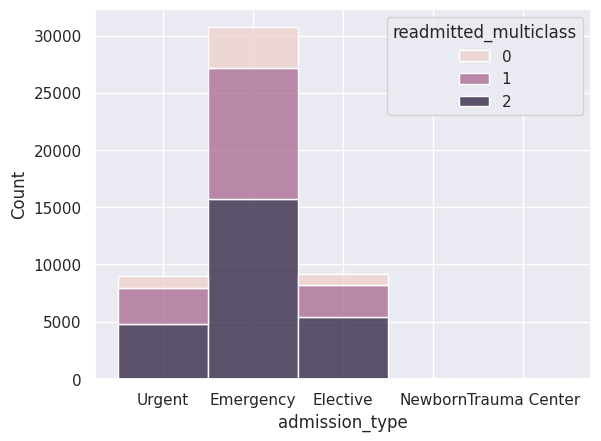

In [118]:
sns.histplot(data = X_train, x = 'admission_type', hue = y_train, multiple = "stack")

In [119]:
# Create a binary variable indicating if the index admission was through the ED
X_train['admitted_urgent/emergency'] = np.nan

# If the admission source is Emergency or Urgent, set 'admitted_urgent/emergency' to 1
X_train.loc[(X_train['admission_type'] == 'Emergency') | (X_train['admission_type'] == 'Urgent'), 'admitted_urgent/emergency'] = 1

# If the admission source is not Emergency and not Urgent, set 'admitted_urgent/emergency' to 0
X_train.loc[(X_train['admission_type'] != 'Emergency') & (X_train['admission_type'] != 'Urgent'), 'admitted_urgent/emergency'] = 0

X_train['admitted_urgent/emergency'].value_counts()

1.0    39718
0.0     9168
Name: admitted_urgent/emergency, dtype: int64

In [120]:
# Repeat for VAL
X_val['admitted_urgent/emergency'] = np.nan

X_val.loc[(X_val['admission_type'] == 'Emergency') | (X_val['admission_type'] == 'Urgent'), 'admitted_urgent/emergency'] = 1

X_val.loc[(X_val['admission_type'] != 'Emergency') & (X_val['admission_type'] != 'Urgent'), 'admitted_urgent/emergency'] = 0

X_val['admitted_urgent/emergency'].value_counts()

1.0    17091
0.0     3938
Name: admitted_urgent/emergency, dtype: int64

medical_speciality: less categories (group the classes that have less than 2 % of observations)

In [121]:
# Surgery
X_train['medical_specialty'].replace({'Surgery-Cardiovascular/Thoracic': 'Surgery', 'Surgery-General': 'Surgery',
                                      'SurgicalSpecialty': 'Surgery', 'Surgery-Vascular': 'Surgery',
                                      'Surgery-Cardiovascular': 'Surgery', 'Surgery-Thoracic': 'Surgery',
                                      'Surgery-Maxillofacial': 'Surgery',  'Surgery-Plastic': 'Surgery',
                                      'Surgeon': 'Surgery', 'Surgery-Pediatric': 'Surgery', 'Surgery-Neuro': 'Surgery',
                                      'Surgery-Colon&Rectal': 'Surgery'}, inplace = True)

X_val['medical_specialty'].replace({'Surgery-Cardiovascular/Thoracic': 'Surgery', 'Surgery-General': 'Surgery',
                                      'SurgicalSpecialty': 'Surgery', 'Surgery-Vascular': 'Surgery',
                                      'Surgery-Cardiovascular': 'Surgery', 'Surgery-Thoracic': 'Surgery',
                                      'Surgery-Maxillofacial': 'Surgery',  'Surgery-Plastic': 'Surgery',
                                      'Surgeon': 'Surgery', 'Surgery-Pediatric': 'Surgery', 'Surgery-Neuro': 'Surgery',
                                      'Surgery-Colon&Rectal': 'Surgery'}, inplace = True)

In [122]:
X_train['medical_specialty'].replace({'Psychiatry-Child/Adolescent': 'Psychiatry'}, inplace = True)

X_val['medical_specialty'].replace({'Psychiatry-Child/Adolescent': 'Psychiatry'}, inplace = True)

In [123]:
X_train['medical_specialty'].replace({'ObstetricsandGynecology': "Women's Health", 'Gynecology': "Women's Health",
                                      'Obsterics&Gynecology-GynecologicOnco': "Women's Health",
                                      'Obstetrics': "Women's Health"}, inplace = True)

X_val['medical_specialty'].replace({'ObstetricsandGynecology': "Women's Health", 'Gynecology': "Women's Health",
                                      'Obsterics&Gynecology-GynecologicOnco': "Women's Health",
                                      'Obstetrics': "Women's Health"}, inplace = True)

<Axes: xlabel='medical_specialty', ylabel='Count'>

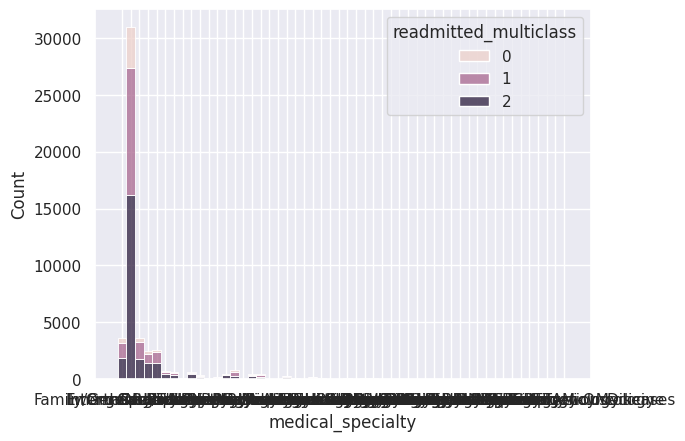

In [124]:
sns.histplot(data = X_train, x = 'medical_specialty', hue = y_train, multiple = "stack")

**discharge_disposition**: less categories (group the classes that have less than 5% of observations)

In [125]:
# Within Facility Transfer
X_train['discharge_disposition'].replace({
            "Discharged/transferred to SNF": "Within Facility Transfer",
            'Discharged/transferred/referred to this institution for outpatient services': "Within Facility Transfer",
            "Discharged/transferred to ICF": "Within Facility Transfer",
            "Discharged/transferred within this institution to Medicare approved swing bed": "Within Facility Transfer",
            'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital': "Within Facility Transfer"}, inplace = True)

X_val['discharge_disposition'].replace({
            "Discharged/transferred to SNF": "Within Facility Transfer",
            'Discharged/transferred/referred to this institution for outpatient services': "Within Facility Transfer",
            "Discharged/transferred to ICF": "Within Facility Transfer",
            "Discharged/transferred within this institution to Medicare approved swing bed": "Within Facility Transfer",
            'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital': "Within Facility Transfer"}, inplace = True)

In [126]:
# Another Facility Transfer
X_train['discharge_disposition'].replace({
    "Discharged/transferred to another short term hospital": "Another Facility Transfer",
    "Discharged/transferred to another rehab fac including rehab units of a hospital .": "Another Facility Transfer",
    "Discharged/transferred/referred another institution for outpatient services": "Another Facility Transfer",
    "Discharged/transferred to a long term care hospital.": "Another Facility Transfer",
    'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.': 'Another Facility Transfer',
    "Discharged/transferred to a federal health care facility.": "Another Facility Transfer",
    'Hospice / medical facility': 'Another Facility Transfer',
    'Discharged/transferred to another type of inpatient care institution': 'Another Facility Transfer'}, inplace = True)

X_val['discharge_disposition'].replace({
    "Discharged/transferred to another short term hospital": "Another Facility Transfer",
    "Discharged/transferred to another rehab fac including rehab units of a hospital .": "Another Facility Transfer",
    "Discharged/transferred/referred another institution for outpatient services": "Another Facility Transfer",
    "Discharged/transferred to a long term care hospital.": "Another Facility Transfer",
    'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.': 'Another Facility Transfer',
    "Discharged/transferred to a federal health care facility.": "Another Facility Transfer",
    'Hospice / medical facility': 'Another Facility Transfer',
    'Discharged/transferred to another type of inpatient care institution': 'Another Facility Transfer'}, inplace = True)

In [127]:
# Home Discharge
X_train['discharge_disposition'].replace({'Discharged to home': 'Home Discharge',
                 'Discharged/transferred to home with home health service': 'Home Discharge',
                 'Discharged/transferred to home under care of Home IV provider': 'Home Discharge',
                 'Hospice / home': 'Home Discharge'}, inplace = True)

X_val['discharge_disposition'].replace({'Discharged to home': 'Home Discharge',
                 'Discharged/transferred to home with home health service': 'Home Discharge',
                 'Discharged/transferred to home under care of Home IV provider': 'Home Discharge',
                 'Hospice / home': 'Home Discharge'}, inplace = True)

In [128]:
# Group 'Expired' patients
X_train['discharge_disposition'].replace({'Expired at home. Medicaid only, hospice.': 'Expired',
                'Expired in a medical facility. Medicaid only, hospice.': 'Expired'}, inplace = True)

X_val['discharge_disposition'].replace({'Expired at home. Medicaid only, hospice.': 'Expired',
                'Expired in a medical facility. Medicaid only, hospice.': 'Expired'}, inplace = True)

In [129]:
# Other Situations
X_train['discharge_disposition'].replace({'Admitted as an inpatient to this hospital': 'Other',
                 'Left AMA': 'Other',
                 'Neonate discharged to another hospital for neonatal aftercare': 'Other'}, inplace = True)

X_val['discharge_disposition'].replace({'Admitted as an inpatient to this hospital': 'Other',
                 'Left AMA': 'Other',
                 'Neonate discharged to another hospital for neonatal aftercare': 'Other'}, inplace = True)

**admission_source**: less categories (group the classes into 4 categories: 'Emergency Room', 'Transfer', 'Referral', 'Other')

In [130]:
X_train['admission_source'].value_counts(normalize = True)

Emergency Room                                               0.565847
Physician Referral                                           0.292517
Not Mapped                                                   0.067790
Transfer from a hospital                                     0.031543
Transfer from another health care facility                   0.021642
Clinic Referral                                              0.010780
Transfer from a Skilled Nursing Facility (SNF)               0.007528
HMO Referral                                                 0.001882
Transfer from critial access hospital                        0.000143
Court/Law Enforcement                                        0.000143
Transfer from hospital inpt/same fac reslt in a sep claim    0.000102
Transfer from Ambulatory Surgery Center                      0.000041
Sick Baby                                                    0.000020
Extramural Birth                                             0.000020
Name: admission_sour

In [131]:
X_train['admission_source'].replace({'Physician Referral': 'Referral', 'Transfer from a hospital': 'Transfer',
                                'Transfer from another health care facility': 'Transfer',
                                'Clinic Referral': 'Referral', 'Transfer from a Skilled Nursing Facility (SNF)': 'Transfer',
                                 'Transfer from hospital inpt/same fac reslt in a sep claim': 'Transfer',
                                 'HMO Referral': 'Referral', 'Court/Law Enforcement': 'Other',
                                 'Transfer from Ambulatory Surgery Center': 'Transfer',
                                 'Transfer from critial access hospital': 'Transfer',
                                 'Extramural Birth': 'Other', 'Normal Delivery': 'Other', 'Sick Baby': 'Other'}, inplace = True)

In [132]:
X_val['admission_source'].replace({'Physician Referral': 'Referral', 'Transfer from a hospital': 'Transfer',
                                'Transfer from another health care facility': 'Transfer',
                                'Clinic Referral': 'Referral', 'Transfer from a Skilled Nursing Facility (SNF)': 'Transfer',
                                 'Transfer from hospital inpt/same fac reslt in a sep claim': 'Transfer',
                                 'HMO Referral': 'Referral', 'Court/Law Enforcement': 'Other',
                                 'Transfer from Ambulatory Surgery Center': 'Transfer',
                                 'Transfer from critial access hospital': 'Transfer',
                                 'Extramural Birth': 'Other', 'Normal Delivery': 'Other', 'Sick Baby': 'Other'}, inplace = True)

<Axes: xlabel='admission_source', ylabel='Count'>

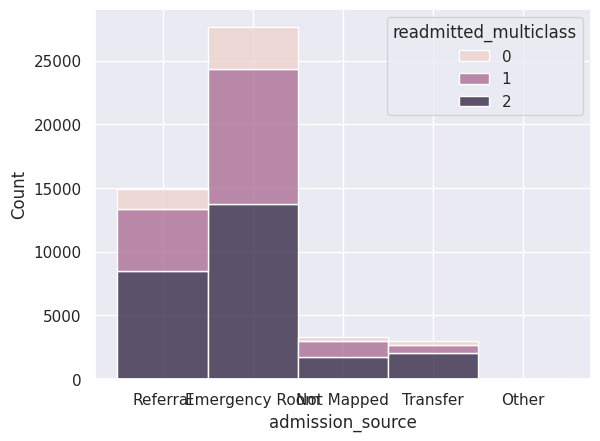

In [133]:
sns.histplot(data = X_train, x = 'admission_source', hue = y_train, multiple = "stack")

**length_of_stay_in_hospital**: Apply the logarithm transformation to make the distribution more normal.

<Axes: xlabel='length_of_stay_in_hospital', ylabel='Count'>

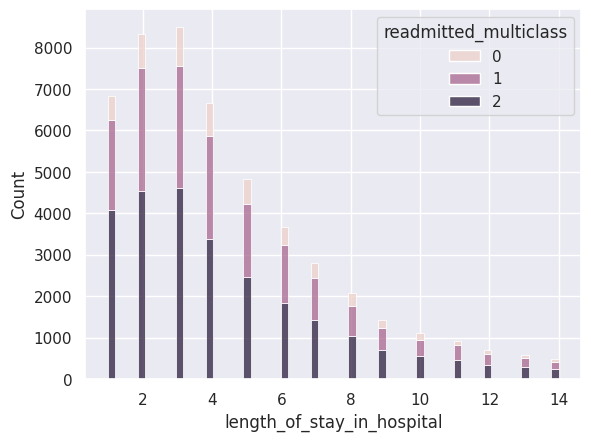

In [134]:
sns.histplot(data = X_train, x = 'length_of_stay_in_hospital', hue = y_train, multiple = "stack")

<Axes: xlabel='length_of_stay_in_hospital', ylabel='Count'>

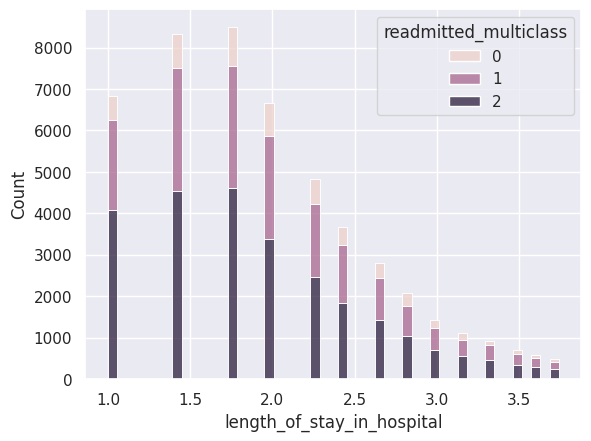

In [135]:
sns.histplot(data = X_train, x = np.sqrt(X_train['length_of_stay_in_hospital']), hue = y_train, multiple = "stack")

<Axes: xlabel='length_of_stay_in_hospital', ylabel='Count'>

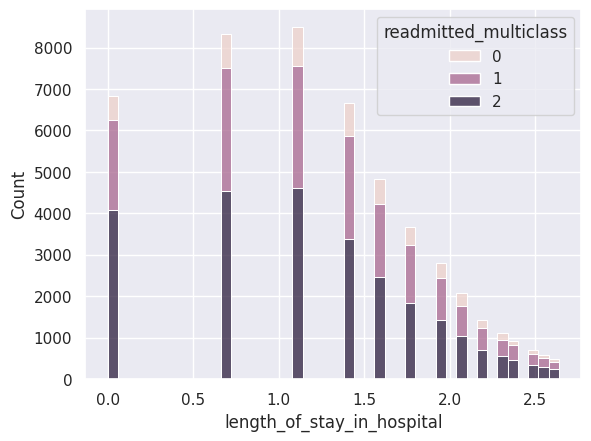

In [136]:
sns.histplot(data = X_train, x = np.log(X_train['length_of_stay_in_hospital']), hue = y_train, multiple = "stack")

In [137]:
X_train['length_of_stay_in_hospital'] = np.log(X_train['length_of_stay_in_hospital'])

In [138]:
X_val['length_of_stay_in_hospital'] = np.log(X_val['length_of_stay_in_hospital'])

**number_of_medications**: Apply the square root transformation to make the distribution more normal.
This transformation helps in normalizing the distribution, mitigating the impact of extreme values and achieve a more symmetric distribution.

<Axes: xlabel='number_of_medications', ylabel='Count'>

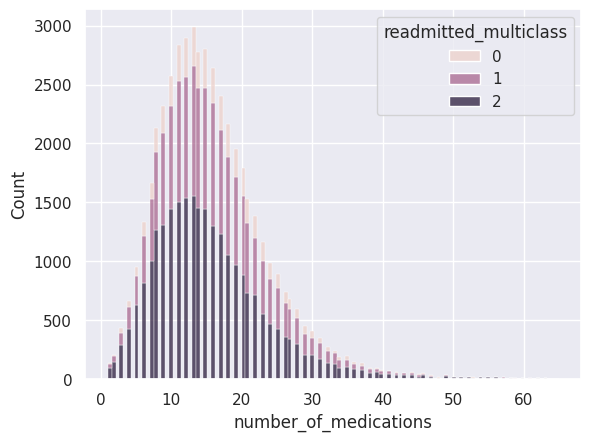

In [139]:
sns.histplot(data = X_train, x = 'number_of_medications', hue = y_train, multiple = "stack")

<Axes: xlabel='number_of_medications', ylabel='Count'>

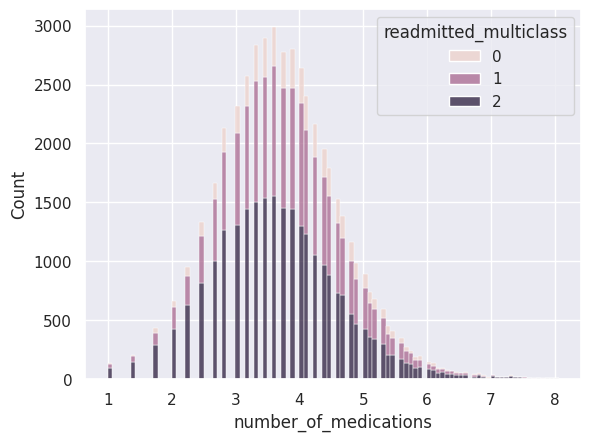

In [140]:
sns.histplot(data = X_train, x = np.sqrt(X_train['number_of_medications']), hue = y_train, multiple = "stack")

<Axes: xlabel='number_of_medications', ylabel='Count'>

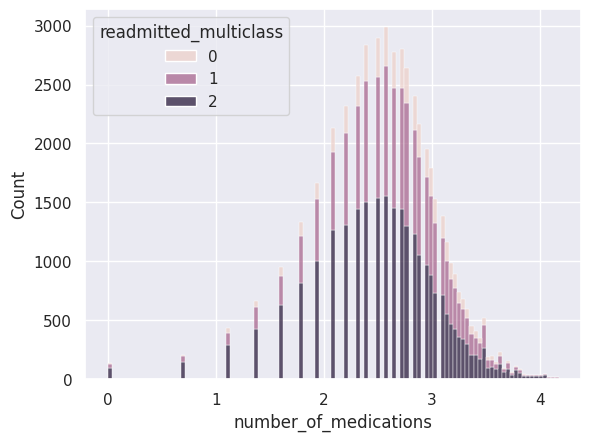

In [141]:
sns.histplot(data = X_train, x = np.log(X_train['number_of_medications']), hue = y_train, multiple = "stack")

In [142]:
X_train['number_of_medications'] = np.sqrt(X_train['number_of_medications'])

In [143]:
X_val['number_of_medications'] = np.sqrt(X_val['number_of_medications'])

**Convert Variables to Dummy**

In [144]:
# Convert the target variable to dummy
X_train['Female'].replace({'No': 0,'Ch': 1}, inplace = True)
X_train['Female'].value_counts()

1    26248
0    22638
Name: Female, dtype: int64

In [145]:
# Convert the target variable to dummy
X_val['Female'].replace({'No': 0,'Ch': 1}, inplace = True)
X_val['Female'].value_counts()

1    11335
0     9694
Name: Female, dtype: int64

In [146]:
# Convert the target variable to dummy
X_train['change_in_meds_during_hospitalization'].replace({'No': 0,'Ch': 1}, inplace = True)
X_train['change_in_meds_during_hospitalization'].value_counts()

0    26166
1    22720
Name: change_in_meds_during_hospitalization, dtype: int64

In [147]:
# Convert the target variable to dummy
X_val['change_in_meds_during_hospitalization'].replace({'No': 0,'Ch': 1}, inplace = True)
X_val['change_in_meds_during_hospitalization'].value_counts()

0    11332
1     9697
Name: change_in_meds_during_hospitalization, dtype: int64

In [148]:
# Convert the target variable to dummy
X_train['prescribed_diabetes_meds'].replace({'No': 0,'Yes': 1}, inplace = True)
X_train['prescribed_diabetes_meds'].value_counts()

1    37676
0    11210
Name: prescribed_diabetes_meds, dtype: int64

In [149]:
# Convert the target variable to dummy
X_val['prescribed_diabetes_meds'].replace({'No': 0,'Yes': 1}, inplace = True)
X_val['prescribed_diabetes_meds'].value_counts()

1    16309
0     4720
Name: prescribed_diabetes_meds, dtype: int64

In [150]:
X_train.columns

Index(['country', 'race', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'total_visits_in_previous_year', 'total_encounters',
       'primary_diagnoses_categories', 'secondary_diagnoses_categories',
       'additional_diagnoses_categories', 'type2', 'diagnosed_diabetes',
       'Female', 'admitted_urgent/emergency'],
      dtype='object')

In [151]:
X_train.head()

,country,race,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,...,medication,total_visits_in_previous_year,total_encounters,primary_diagnoses_categories,secondary_diagnoses_categories,additional_diagnoses_categories,type2,diagnosed_diabetes,Female,admitted_urgent/emergency
encounter_id,,,,,,,,,,,,,,,,,,,,,
160076,USA,Caucasian,65,No Insurance,0,0,0,Urgent,Family/GeneralPractice,79,...,"['pioglitazone', 'insulin']",0,1,Diseases of the Circulatory System,Diseases of the Circulatory System,Diseases of the Circulatory System,0.0,0.0,0,1.0
170876,USA,Caucasian,65,Other,3,0,0,Emergency,InternalMedicine,79,...,No Medication,3,1,Diseases of the Circulatory System,Diseases of the Genitourinary System,Diseases of the Respiratory System,0.0,0.0,1,1.0
644304,USA,Caucasian,95,MC,0,0,0,Emergency,InternalMedicine,91,...,"['glyburide', 'insulin']",0,1,Diseases of the Respiratory System,Diseases of the Respiratory System,"Endocrine, Nutritional, and Metabolic Diseases...",0.0,0.0,1,1.0
487584,USA,Caucasian,55,MC,0,0,0,Emergency,InternalMedicine,122,...,['insulin'],0,3,Diseases of the Respiratory System,Diseases of the Genitourinary System,Infectious and Parasitic Diseases,0.0,0.0,1,1.0
296497,USA,Caucasian,95,No Insurance,0,0,0,Emergency,InternalMedicine,75,...,No Medication,0,1,Diseases of the Digestive System,"Endocrine, Nutritional, and Metabolic Diseases...",Diseases of the Circulatory System,0.0,0.0,1,1.0


In [152]:
X_train.columns

Index(['country', 'race', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'total_visits_in_previous_year', 'total_encounters',
       'primary_diagnoses_categories', 'secondary_diagnoses_categories',
       'additional_diagnoses_categories', 'type2', 'diagnosed_diabetes',
       'Female', 'admitted_urgent/emergency'],
      dtype='object')

In [153]:
metric_features = metric_features + ['total_visits_in_previous_year','age' ]

In [154]:
metric_features

['outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'total_encounters',
 'total_visits_in_previous_year',
 'age']

In [155]:
for column in X_train.columns:
    if X_train[column].nunique() == 2:
        print(f"Variable '{column}' has just 2 categories.")

Variable 'change_in_meds_during_hospitalization' has just 2 categories.
Variable 'prescribed_diabetes_meds' has just 2 categories.
Variable 'type2' has just 2 categories.
Variable 'diagnosed_diabetes' has just 2 categories.
Variable 'Female' has just 2 categories.
Variable 'admitted_urgent/emergency' has just 2 categories.


In [156]:
non_metric_features = non_metric_features + ['primary_diagnoses_categories', 'secondary_diagnoses_categories',
       'additional_diagnoses_categories', 'type2', 'diagnosed_diabetes',
       'Female', 'admitted_urgent/emergency']

binary = ['Female', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'type2',  'diagnosed_diabetes',
          'admitted_urgent/emergency']

In [157]:
non_metric_features.remove("age")

In [158]:
non_metric_features_wout_binary = [feature for feature in non_metric_features if feature not in binary]

In [159]:
all_features_wout_binary = non_metric_features_wout_binary + metric_features

# Scale dataset

In [160]:
X_train_unscalled = X_train.copy()

In [161]:
# Target encoding for Train and Validation
# We fit to train and transform for train and validation
encoder = ce.TargetEncoder()

# Iterate through the non-metric features
for column in non_metric_features_wout_binary:
    # Fit the TargetEncoder using X_train and y_train
    encoder.fit(X_train[[column]], y_train)

    # Transform both X_train and X_val
    X_train[column] = encoder.transform(X_train[[column]])
    X_val[column] = encoder.transform(X_val[[column]])

In [162]:
scaler = MinMaxScaler()

# Iterate through the metric features
for column in all_features_wout_binary:
    # Fit the scaler on the current column
    scaler.fit(X_train[[column]])

    # Transform both X_train and X_val
    X_train[column] = scaler.transform(X_train[[column]])
    X_val[column] = scaler.transform(X_val[[column]])

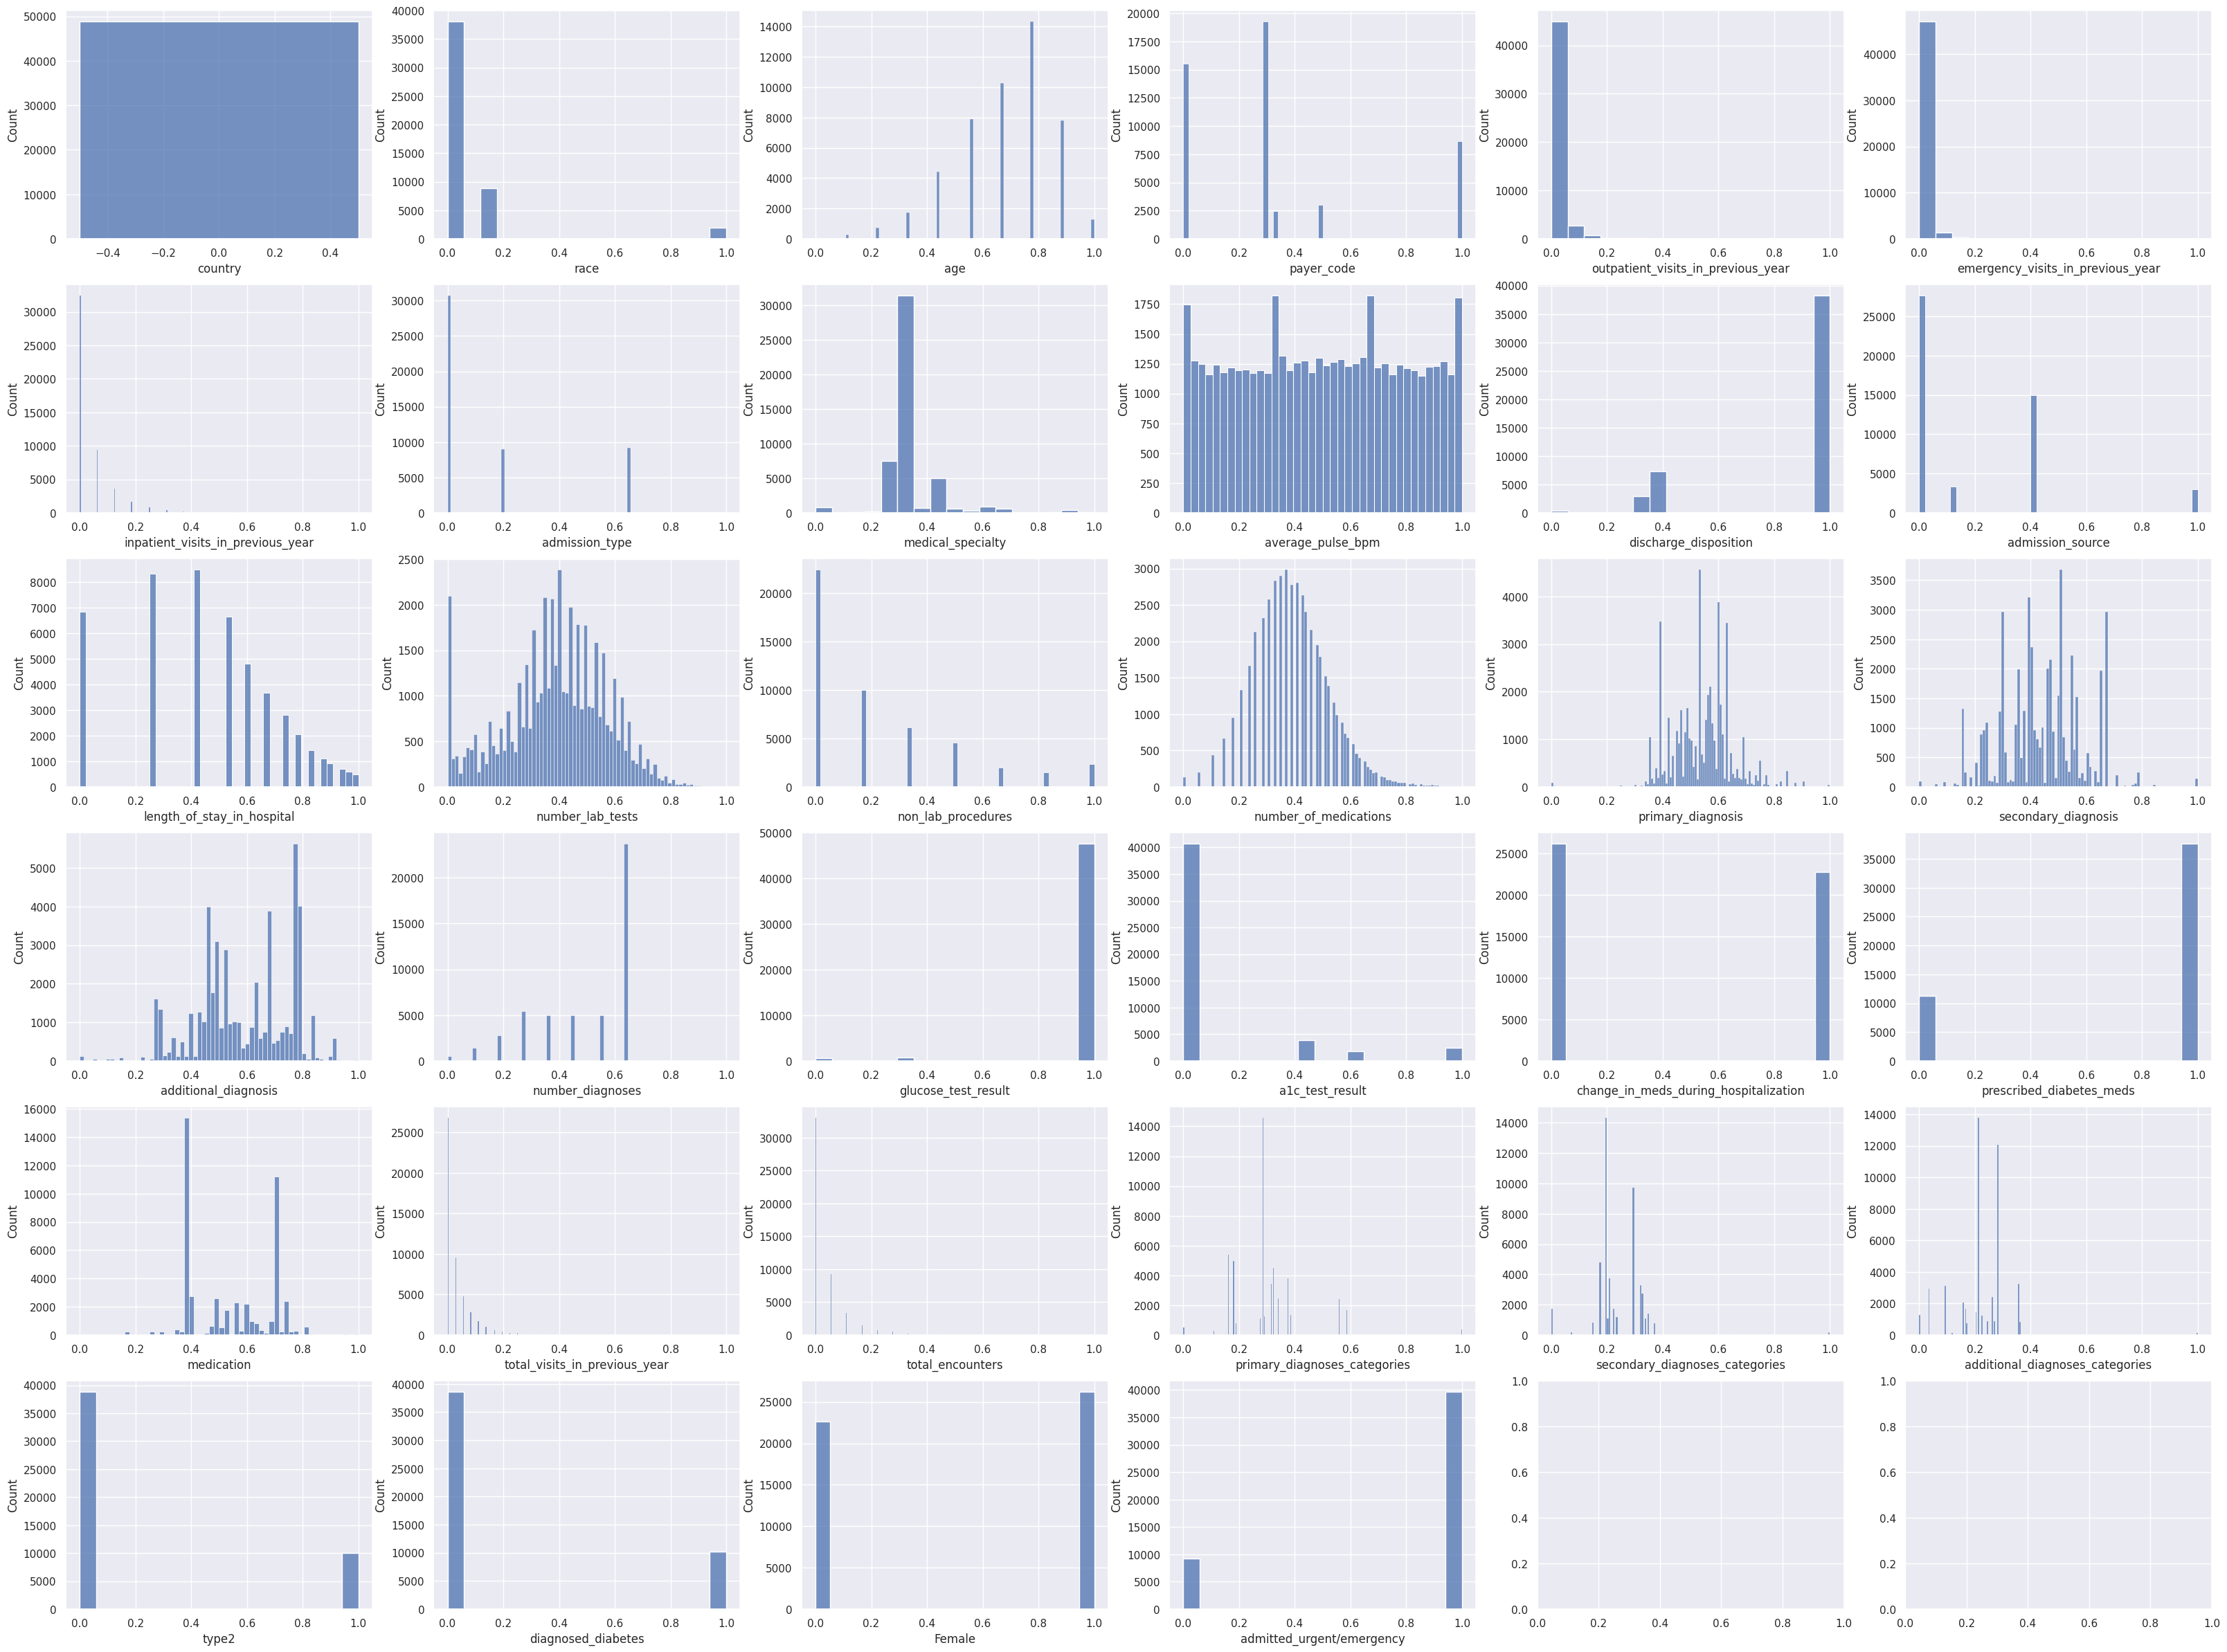

In [163]:
# Check the Distribution of the Features AFTER SCALLING
sns.set()
fig, axes = plt.subplots(6, ceil(len(X_train.columns) / 6), figsize=(40, 30))

for ax, feat in zip(axes.flatten(), X_train.columns):
    sns.histplot(x = X_train[feat], ax = ax)

plt.show()

In [164]:
X_train

,country,race,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,...,medication,total_visits_in_previous_year,total_encounters,primary_diagnoses_categories,secondary_diagnoses_categories,additional_diagnoses_categories,type2,diagnosed_diabetes,Female,admitted_urgent/emergency
encounter_id,,,,,,,,,,,,,,,,,,,,,
160076,0.0,0.0,0.666667,0.300525,0.000000,0.0,0.000,0.197299,0.288703,0.240506,...,0.483979,0.000000,0.000000,0.285325,0.197656,0.212976,0.0,0.0,0,1.0
170876,0.0,0.0,0.666667,1.000000,0.103448,0.0,0.000,0.000000,0.314325,0.240506,...,0.702913,0.083333,0.000000,0.285325,0.210572,0.091124,0.0,0.0,1,1.0
644304,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000,0.000000,0.314325,0.392405,...,0.559440,0.000000,0.000000,0.180937,0.174597,0.281545,0.0,0.0,1,1.0
487584,0.0,0.0,0.555556,0.000000,0.000000,0.0,0.000,0.000000,0.314325,0.784810,...,0.376240,0.000000,0.111111,0.180937,0.210572,0.117987,0.0,0.0,1,1.0
296497,0.0,0.0,1.000000,0.300525,0.000000,0.0,0.000,0.000000,0.314325,0.189873,...,0.702913,0.000000,0.000000,0.323960,0.296532,0.212976,0.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465401,0.0,1.0,0.444444,0.300525,0.103448,0.0,0.125,0.197299,0.314325,0.708861,...,0.376240,0.138889,0.166667,0.341338,0.296532,0.165907,0.0,0.0,0,1.0
961904,0.0,0.0,0.777778,1.000000,0.000000,0.0,0.000,0.650114,0.460821,0.822785,...,0.504595,0.000000,0.000000,0.285325,0.197656,0.035356,0.0,0.0,0,0.0
995085,0.0,0.0,0.888889,1.000000,0.000000,0.0,0.000,0.000000,0.314325,0.443038,...,0.173677,0.000000,0.000000,0.384910,0.197656,0.035356,0.0,0.0,0,1.0


# Balance dataset

In [165]:
smote_enn = SMOTEENN(sampling_strategy='auto')

# Fit and transform the training data using SMOTE-ENN
X_smote, y_smote = smote_enn.fit_resample(X_train, y_train)


In [166]:
print(X_smote.shape)
print(y_smote.shape)

(37279, 34)
(37279,)


# **Feature Selection**

**Features' Variance**

In [167]:
# Univariate variables: Check the variance of each feature identify those with no variability.
# Features with no variance should be removed.
variance_smote = X_smote.var().round(10)*100
print(variance_smote)

variance_train = X_train.var().round(10)*100

country                                   0.000000
race                                      2.958045
age                                       2.567171
payer_code                               10.301163
outpatient_visits_in_previous_year        0.131153
emergency_visits_in_previous_year         0.092133
inpatient_visits_in_previous_year         0.849749
admission_type                            5.776324
medical_specialty                         0.818058
average_pulse_bpm                         7.510455
discharge_disposition                     7.859493
admission_source                          6.590803
length_of_stay_in_hospital                6.071422
number_lab_tests                          2.680481
non_lab_procedures                        6.522379
number_of_medications                     1.503481
primary_diagnosis                         0.914081
secondary_diagnosis                       1.667558
additional_diagnosis                      2.487936
number_diagnoses               

In [168]:
for threshold in [0.1]:
    low_variance_smote = variance_smote[variance_smote < threshold].index
    print(f"Threshold: {threshold}, Low-variance features: {low_variance_smote}")

Threshold: 0.1, Low-variance features: Index(['country', 'emergency_visits_in_previous_year'], dtype='object')


In [169]:
# Drop the column country because it has only one value, so it won´t give use any valuable insights
X_smote.drop("country", axis = 1, inplace= True)
X_val.drop("country", axis = 1, inplace= True)
non_metric_features.remove('country')
all_features_wout_binary.remove('country')

In [170]:
X_train.drop("country", axis = 1, inplace= True)

In [171]:
variance_eliminate = ['emergency_visits_in_previous_year']

**Correlation Matrices**

In [172]:
X_smote[metric_features].columns

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'total_encounters',
       'total_visits_in_previous_year', 'age'],
      dtype='object')

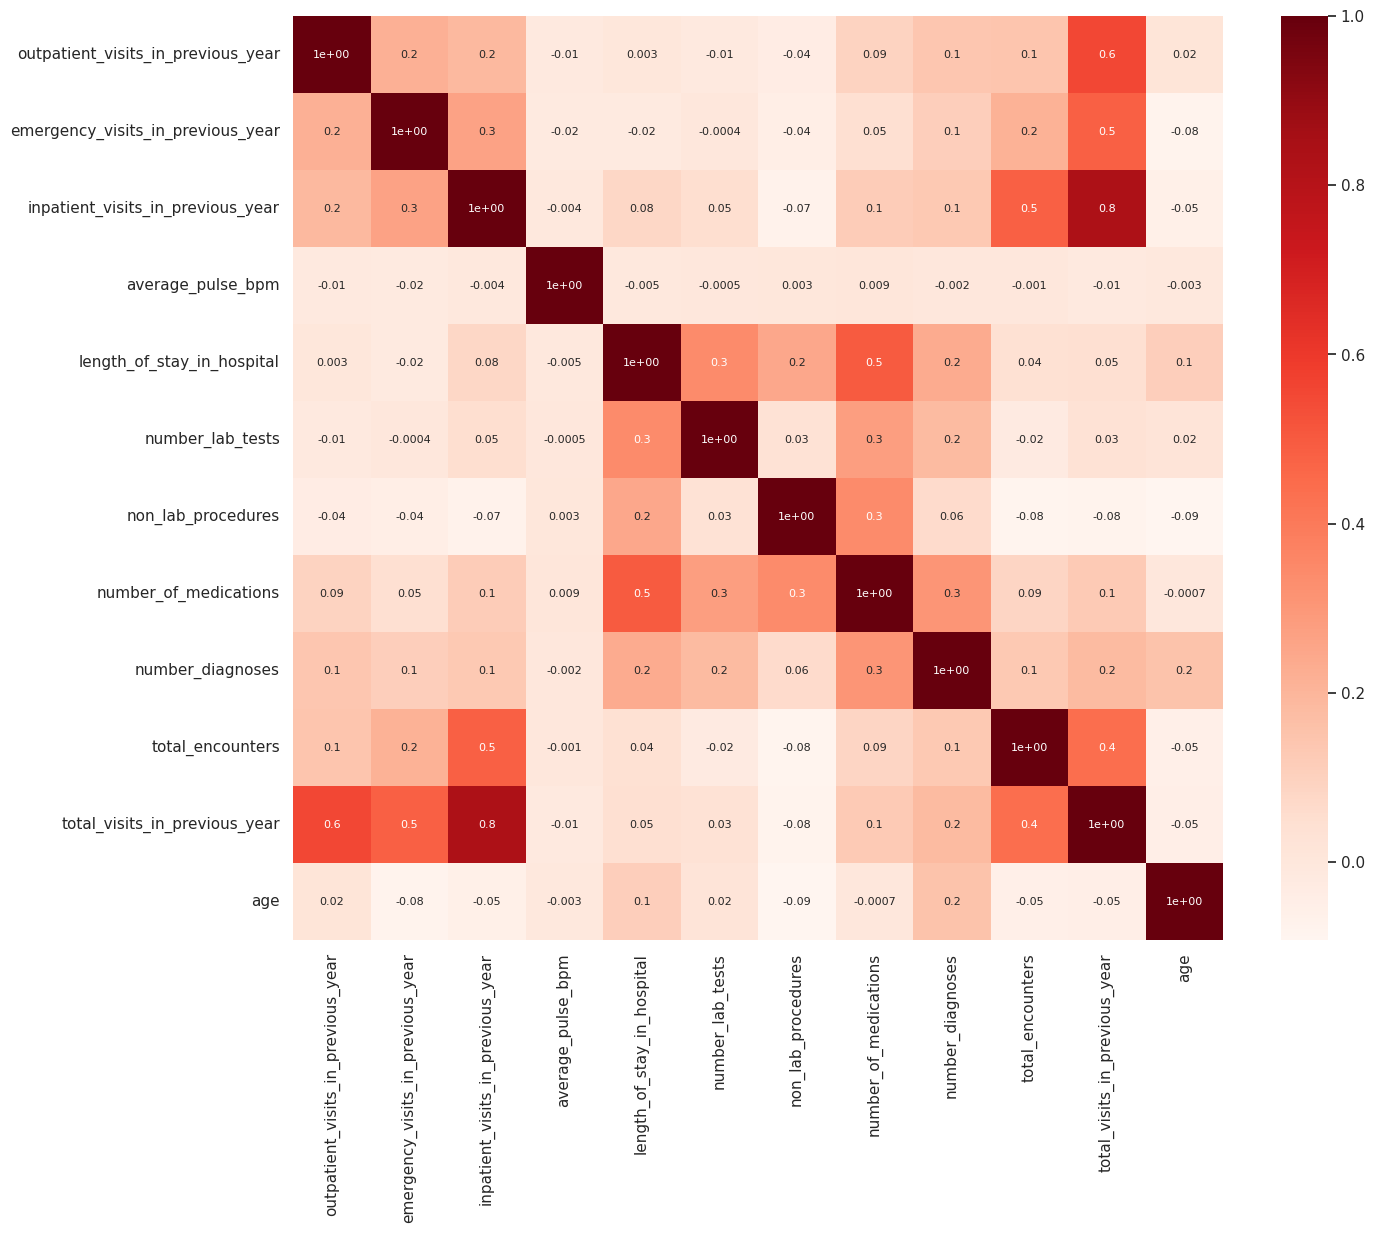

In [173]:
# Spearman Correlation for metric features

def cor_heatmap(cor):
    plt.figure(figsize=(15,12))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1', annot_kws = {"size": 8})
    plt.show()

cor_spearman = X_smote[metric_features].corr(method ='spearman')

cor_heatmap(cor_spearman)

In [174]:
spearman_eliminate = ['total_visits_in_previous_year']

**Chi-Square** for Categorical Features

In [175]:
# Chi-Square para categorical features

chi_square_eliminate = []

def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
        chi_square_eliminate.append(var)
    print(result)

for var in non_metric_features:
    TestIndependence(X_smote[var], y_smote, var)

race is NOT an important predictor. (Discard race from model)
payer_code is NOT an important predictor. (Discard payer_code from model)
admission_type is NOT an important predictor. (Discard admission_type from model)
medical_specialty is NOT an important predictor. (Discard medical_specialty from model)
discharge_disposition is NOT an important predictor. (Discard discharge_disposition from model)
admission_source is NOT an important predictor. (Discard admission_source from model)
primary_diagnosis is NOT an important predictor. (Discard primary_diagnosis from model)
secondary_diagnosis is NOT an important predictor. (Discard secondary_diagnosis from model)
additional_diagnosis is NOT an important predictor. (Discard additional_diagnosis from model)
glucose_test_result is NOT an important predictor. (Discard glucose_test_result from model)
a1c_test_result is NOT an important predictor. (Discard a1c_test_result from model)
change_in_meds_during_hospitalization is IMPORTANT for Predict

In [176]:
chi_square_eliminate

['race',
 'payer_code',
 'admission_type',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'glucose_test_result',
 'a1c_test_result',
 'medication',
 'primary_diagnoses_categories',
 'secondary_diagnoses_categories',
 'additional_diagnoses_categories',
 'diagnosed_diabetes']

**RFE (Recursive Feature Elimination)**

In [177]:
# RFE USING LOGISTIC REGRESSION
#This time we are going to apply Recursive Feature Elimination (RFE / Backwards) that will allow to select the most important features to keep.

In [178]:
len(X_smote.columns)

33

In [179]:
#rfe
nof_list = np.arange(1, 13)
high_score = 0
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression(random_state=42)

    # Use step parameter to control the number of features to remove at each iteration
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])

    X_train_rfe = rfe.fit_transform(X_smote, y_smote)
    X_val_rfe = rfe.transform(X_val)

    model.fit(X_train_rfe, y_smote)

    # storing results on training data
    train_pred = model.predict(X_train_rfe)
    train_score = f1_score(y_smote, train_pred, average='weighted')
    train_score_list.append(train_score)

    # storing results on validation data
    val_pred = model.predict(X_val_rfe)
    val_score = f1_score(y_val, val_pred, average='weighted')
    val_score_list.append(val_score)

    # check best score
    if (val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.247128


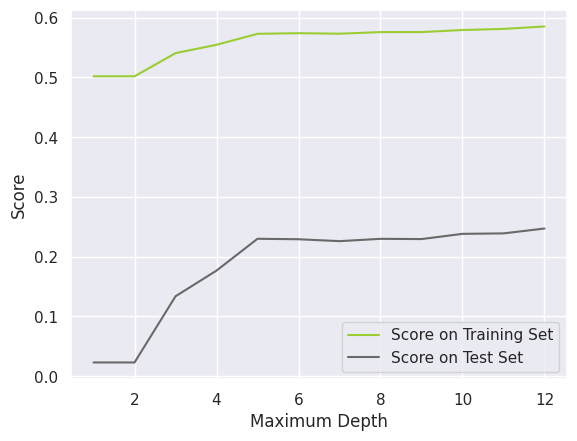

In [180]:
plt.plot(list(range(1,13)), train_score_list, label = "Score on Training Set", color = 'yellowgreen')
plt.plot(list(range(1,13)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

In [181]:
model = LogisticRegression(random_state=42)
rfe = RFE(estimator = model, n_features_to_select = 12)

X_rfe = rfe.fit_transform(X_smote, y_smote)

In [182]:
# Evaluate what columns should we keep based on RFE
pd.Series(rfe.support_, index = X_smote.columns)

race                                     False
age                                       True
payer_code                               False
outpatient_visits_in_previous_year       False
emergency_visits_in_previous_year         True
inpatient_visits_in_previous_year         True
admission_type                           False
medical_specialty                        False
average_pulse_bpm                        False
discharge_disposition                     True
admission_source                          True
length_of_stay_in_hospital               False
number_lab_tests                         False
non_lab_procedures                       False
number_of_medications                    False
primary_diagnosis                         True
secondary_diagnosis                       True
additional_diagnosis                      True
number_diagnoses                          True
glucose_test_result                      False
a1c_test_result                          False
change_in_med

In [183]:
rfe_eliminate = []

rfe_dataset = pd.Series(rfe.support_, index = X_smote.columns)

for index, value in rfe_dataset.items():
    if not value:
        rfe_eliminate.append(index)

In [184]:
rfe_eliminate

['race',
 'payer_code',
 'outpatient_visits_in_previous_year',
 'admission_type',
 'medical_specialty',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'primary_diagnoses_categories',
 'secondary_diagnoses_categories',
 'additional_diagnoses_categories',
 'type2',
 'diagnosed_diabetes',
 'Female',
 'admitted_urgent/emergency']

**LASSO**

In [185]:
# Lasso
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [186]:
reg = LassoCV()
reg.fit(X_smote, y_smote)

coef = pd.Series(reg.coef_, index = X_smote.columns).round(6)
coef

race                                     0.000000
age                                     -0.000000
payer_code                               0.061978
outpatient_visits_in_previous_year      -0.000000
emergency_visits_in_previous_year       -0.000000
inpatient_visits_in_previous_year       -0.000000
admission_type                           0.000000
medical_specialty                        0.000000
average_pulse_bpm                        0.000000
discharge_disposition                    0.262572
admission_source                         0.129833
length_of_stay_in_hospital              -0.064027
number_lab_tests                        -0.000000
non_lab_procedures                       0.010857
number_of_medications                   -0.000000
primary_diagnosis                        0.299665
secondary_diagnosis                      0.270518
additional_diagnosis                     0.486976
number_diagnoses                        -0.071671
glucose_test_result                      0.000000


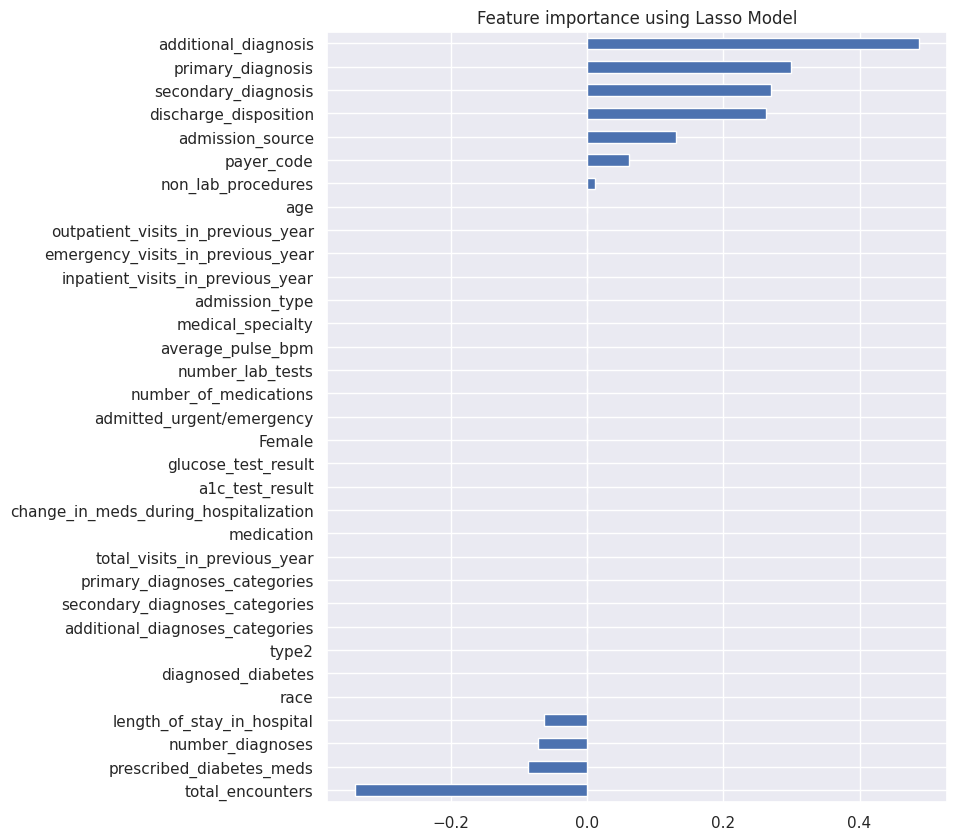

In [187]:
plot_importance(coef,'Lasso')

In [188]:
selected_variables = (coef >= -0.15) & (coef <= 0.15)

# Create a list 'lasso_eliminate' with the selected variables
lasso_eliminate = coef.index[selected_variables].tolist()

# Print 'lasso_eliminate'
print("Variables to eliminate with Lasso:", lasso_eliminate)

Variables to eliminate with Lasso: ['race', 'age', 'payer_code', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'admission_type', 'medical_specialty', 'average_pulse_bpm', 'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'glucose_test_result', 'a1c_test_result', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'medication', 'total_visits_in_previous_year', 'primary_diagnoses_categories', 'secondary_diagnoses_categories', 'additional_diagnoses_categories', 'type2', 'diagnosed_diabetes', 'Female', 'admitted_urgent/emergency']


Decision tree

race: 0.014
age: 0.039
payer_code: 0.029
outpatient_visits_in_previous_year: 0.014
emergency_visits_in_previous_year: 0.01
inpatient_visits_in_previous_year: 0.024
admission_type: 0.011
medical_specialty: 0.026
average_pulse_bpm: 0.057
discharge_disposition: 0.029
admission_source: 0.021
length_of_stay_in_hospital: 0.038
number_lab_tests: 0.052
non_lab_procedures: 0.032
number_of_medications: 0.045
primary_diagnosis: 0.06
secondary_diagnosis: 0.051
additional_diagnosis: 0.052
number_diagnoses: 0.055
glucose_test_result: 0.008
a1c_test_result: 0.013
change_in_meds_during_hospitalization: 0.007
prescribed_diabetes_meds: 0.004
medication: 0.042
total_visits_in_previous_year: 0.037
total_encounters: 0.107
primary_diagnoses_categories: 0.034
secondary_diagnoses_categories: 0.035
additional_diagnoses_categories: 0.038
type2: 0.004
diagnosed_diabetes: 0.005
Female: 0.008
admitted_urgent/emergency: 0.002


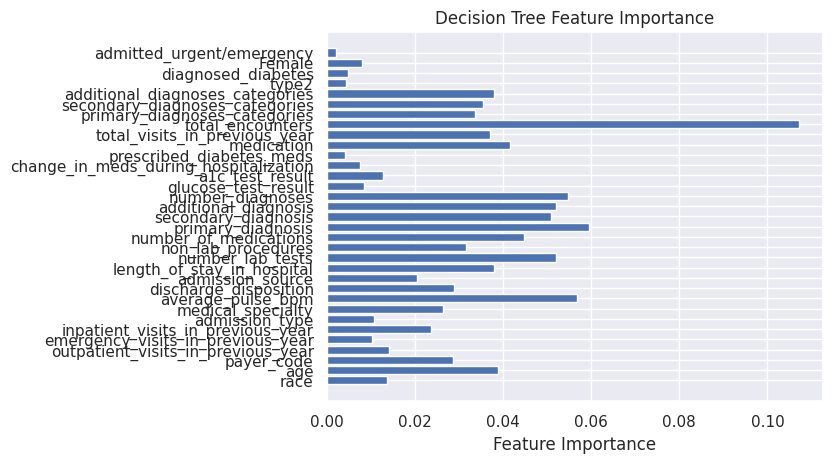

In [189]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state = 42)

# Fit the classifier on the training data
clf.fit(X_smote, y_smote)

# Get feature importances
feature_importances = clf.feature_importances_

decision_tree_eliminate = []

# Print feature importances
for feature, importance in zip(X_smote.columns, feature_importances):
    print(f"{feature}: {importance.round(3)}")
    if importance < 0.025:
      decision_tree_eliminate.append(feature)


# Plot feature importances
plt.barh(X_smote.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.show()

In [190]:
decision_tree_eliminate

['race',
 'outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'admission_type',
 'admission_source',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'type2',
 'diagnosed_diabetes',
 'Female',
 'admitted_urgent/emergency']

In [191]:
from collections import Counter
# Check which features we'll drop based on all methods

all_eliminate = (
    variance_eliminate
    + spearman_eliminate
    + chi_square_eliminate
    + rfe_eliminate
    + lasso_eliminate
    + decision_tree_eliminate
)

element_counts = Counter(all_eliminate)

# Specify the minimum number of appearances for a feature to be dropped
min_appearances = 3
common_elements = [element for element, count in element_counts.items() if count >= min_appearances]

# Print common elements
print(common_elements)

['emergency_visits_in_previous_year', 'race', 'payer_code', 'admission_type', 'medical_specialty', 'admission_source', 'glucose_test_result', 'a1c_test_result', 'primary_diagnoses_categories', 'secondary_diagnoses_categories', 'additional_diagnoses_categories', 'diagnosed_diabetes', 'outpatient_visits_in_previous_year', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'type2', 'Female', 'admitted_urgent/emergency']


In [192]:
X_train.drop(common_elements, axis=1, inplace=True)
X_val.drop(common_elements, axis=1, inplace=True)
X_smote.drop(common_elements, axis=1, inplace=True)

# **Predictive Modelling**

In [193]:
# Confusion Matrix and Model Assessment Metrics
def metrics(y_train, pred_train, y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                TRAIN                                                      ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

### **Logistic Regression**

In [194]:
'''from sklearn.model_selection import RandomizedSearchCV

param_grid={
        'class_weight': ['balanced'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l1', 'l2'],
        'n_jobs': [-1]
    }

logreg = LogisticRegression()

random_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, verbose=0)

# Fit the model to the data
result = random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = result.best_params_
best_model = result.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'from sklearn.model_selection import RandomizedSearchCV\n\nparam_grid={\n        \'class_weight\': [\'balanced\'],\n        \'C\': np.logspace(-4, 4, 20),\n        \'solver\': [\'lbfgs\', \'newton-cg\', \'sag\'],\n        \'penalty\': [\'l1\', \'l2\'],\n        \'n_jobs\': [-1]\n    }\n\nlogreg = LogisticRegression()\n\nrandom_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, verbose=0)\n\n# Fit the model to the data\nresult = random_search.fit(X_train, y_train)\n\n# Get the best parameters and model\nbest_params = result.best_params_\nbest_model = result.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [195]:
#Logistic with params from random search
log_model_gs = LogisticRegression(C=172.79373898388363, class_weight='balanced', max_iter=100, multi_class='multinomial', n_jobs=-1, penalty=None, solver='sag').fit(X_train, y_train)

log_pred_train_gs = log_model_gs.predict(X_train)
log_pred_val_gs = log_model_gs.predict(X_val)

#metrics(y_train, log_pred_train_gs, y_val, log_pred_val_gs)
print('f1_train:',f1_score(y_train, log_pred_train_gs, average='weighted').round(2))
print('f1_val:',f1_score(y_val, log_pred_val_gs, average='weighted').round(2))

f1_train: 0.59
f1_val: 0.54


### **Naive Bayes**

In [196]:
# Random Search for NB

'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import ComplementNB

model_nb = ComplementNB()
param_distributions = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,20,30,40,50,60,70,80,90, 100],
    'fit_prior': [True, False],
    'norm': [True, False]
}
n_iter_search = 20
random_search = RandomizedSearchCV(model_nb, param_distributions=param_distributions, n_iter=n_iter_search, cv=5)
result_nb = random_search.fit(X_smote, y_smote)

best_params = result_nb.best_params_
best_model = result_nb.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.naive_bayes import ComplementNB\n\nmodel_nb = ComplementNB()\nparam_distributions = {\n    \'alpha\': [0.0001, 0.001, 0.01, 0.1, 1, 10,20,30,40,50,60,70,80,90, 100],\n    \'fit_prior\': [True, False],\n    \'norm\': [True, False]\n}\nn_iter_search = 20\nrandom_search = RandomizedSearchCV(model_nb, param_distributions=param_distributions, n_iter=n_iter_search, cv=5)\nresult_nb = random_search.fit(X_smote, y_smote)\n\nbest_params = result_nb.best_params_\nbest_model = result_nb.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [197]:
# Naive Bayes with random search params
nb_model_rs = ComplementNB(alpha= 40, fit_prior=True, norm=False).fit(X_smote, y_smote)

NB_pred_train = nb_model_rs.predict(X_smote)
NB_pred_val = nb_model_rs.predict(X_val)

#metrics(y_smote, NB_pred_train, y_val, NB_pred_val)
print('f1_train:',f1_score(y_smote, NB_pred_train, average='weighted').round(2))
print('f1_val:',f1_score(y_val, NB_pred_val, average='weighted').round(2))

f1_train: 0.52
f1_val: 0.45


### **KNN**

In [198]:
# Random Search for KNN

'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier()
param_distributions = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}
n_iter_search = 20
random_search = RandomizedSearchCV(modelKNN, param_distributions=param_distributions, n_iter=n_iter_search, cv=5)
result_knn = random_search.fit(X_train, y_train)

best_params = result_knn.best_params_
best_model = result_knn.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.neighbors import KNeighborsClassifier\n\nmodelKNN = KNeighborsClassifier()\nparam_distributions = {\n    \'n_neighbors\': [5, 10, 15, 20, 25],\n    \'weights\': [\'uniform\', \'distance\'],\n    \'algorithm\': [\'auto\', \'ball_tree\', \'kd_tree\', \'brute\'],\n    \'leaf_size\': [10, 20, 30, 40, 50],\n    \'p\': [1, 2]\n}\nn_iter_search = 20\nrandom_search = RandomizedSearchCV(modelKNN, param_distributions=param_distributions, n_iter=n_iter_search, cv=5)\nresult_knn = random_search.fit(X_train, y_train)\n\nbest_params = result_knn.best_params_\nbest_model = result_knn.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [199]:
# KNN with random search params
modelKNN = KNeighborsClassifier(algorithm='kd_tree', leaf_size=50, n_neighbors=25, p=1, weights='uniform')
modelKNN.fit(X_train, y_train)

KNN_pred_train = modelKNN.predict(X_train)
KNN_pred_val = modelKNN.predict(X_val)

#metrics(y_train, KNN_pred_train, y_val, KNN_pred_val)
print('f1_train:',f1_score(y_train, KNN_pred_train, average='weighted').round(2))
print('f1_val:',f1_score(y_val, KNN_pred_val, average='weighted').round(2))

f1_train: 0.56
f1_val: 0.49


### **MLP**

In [200]:
# MLP with random search params (from other notebook)
MLPmodel = MLPClassifier(activation = 'tanh', batch_size = 50, hidden_layer_sizes = (15, 10, 15), learning_rate = 'adaptive', solver = 'adam')
MLPmodel.fit(X_smote, y_smote)

MLP_pred_train = MLPmodel.predict(X_smote)
MLP_pred_val = MLPmodel.predict(X_val)

#metrics(y_smote, MLP_pred_train, y_val, MLP_pred_val)
print('f1_train:',f1_score(y_smote, MLP_pred_train, average='weighted').round(2))
print('f1_val:',f1_score(y_val, MLP_pred_val, average='weighted').round(2))

f1_train: 0.63
f1_val: 0.36


### **Decition Trees**

In [201]:
'''# ------- FIND THE BEST VALUE FOR MAX_DEPTH
# 'None': expand the nodes until all leaves are pure (unless other parameters are defined)
# High Depth: increase the number of slipts and captures more information about the data -> OVERFIT
# Small Depth: UNDERFIT

depth_range = range(1, 16)
avg_f1_train = []
avg_f1_val = []

# Perform StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

for depth in depth_range:
    f1_scores_train = []
    f1_scores_val = []

    for train_index, val_index in skf.split(X_train_selection, y_resampled):
        X_train_selection, X_val_selection = X_train_selection.iloc[train_index], X_val_selection.iloc[val_index]
        y_resampled, y_val = y_resampled.iloc[train_index], y_val.iloc[val_index]

        # Create a Decision Tree model with the current depth
        dt_model = DecisionTreeClassifier(max_depth = depth, random_state = 42)
        dt_model.fit(X_train_selection, y_resampled)

        # Predictions on training set
        y_train_pred = dt_model.predict(X_train_selection)
        f1_train = f1_score(y_train, y_train_pred, average = 'macro')
        f1_scores_train.append(f1_train)

        # Predictions on validation set
        y_val_pred = dt_model.predict(X_val_selection)
        f1_val = f1_score(y_val, y_val_pred, average = 'macro')
        f1_scores_val.append(f1_val)

    avg_f1_train.append(np.mean(f1_scores_train))
    avg_f1_val.append(np.mean(f1_scores_val))

# Find the depth associated with the highest F1 score
best_depth_train = depth_range[np.argmax(avg_f1_train)]
best_depth_val = depth_range[np.argmax(avg_f1_val)]

# Plotting
plt.plot(depth_range, avg_f1_train, label='Train F1 Score', marker='o')
plt.plot(depth_range, avg_f1_val, label='Validation F1 Score', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Average F1 Score')
plt.title('Average F1 Score vs Tree Depth')
plt.legend()
plt.show()

# The best max_depth = 9/10'''

"# ------- FIND THE BEST VALUE FOR MAX_DEPTH\n# 'None': expand the nodes until all leaves are pure (unless other parameters are defined)\n# High Depth: increase the number of slipts and captures more information about the data -> OVERFIT\n# Small Depth: UNDERFIT\n\ndepth_range = range(1, 16)\navg_f1_train = []\navg_f1_val = []\n\n# Perform StratifiedKFold cross-validation\nskf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)\n\nfor depth in depth_range:\n    f1_scores_train = []\n    f1_scores_val = []\n\n    for train_index, val_index in skf.split(X_train_selection, y_resampled):\n        X_train_selection, X_val_selection = X_train_selection.iloc[train_index], X_val_selection.iloc[val_index]\n        y_resampled, y_val = y_resampled.iloc[train_index], y_val.iloc[val_index]\n\n        # Create a Decision Tree model with the current depth\n        dt_model = DecisionTreeClassifier(max_depth = depth, random_state = 42)\n        dt_model.fit(X_train_selection, y_resamp

In [202]:
'''# ------- FEATURE IMPORTANCE OF GINI AND ENTROPY
gini_importance = DecisionTreeClassifier().fit(X_smote, y_smote).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_smote, y_smote).feature_importances_

import seaborn as sns
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_smote.columns
tidy = zippy.melt(id_vars='col').rename(columns = str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)'''

"# ------- FEATURE IMPORTANCE OF GINI AND ENTROPY\ngini_importance = DecisionTreeClassifier().fit(X_smote, y_smote).feature_importances_\nentropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_smote, y_smote).feature_importances_\n\nimport seaborn as sns\nzippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])\nzippy['col'] = X_smote.columns\ntidy = zippy.melt(id_vars='col').rename(columns = str.title)\ntidy.sort_values(['Value'], ascending = False, inplace = True)\n\nplt.figure(figsize=(15,8))\nsns.barplot(y='Col', x='Value', hue='Variable', data=tidy)"

In [203]:
# DT with RS (params from another notebook's random search)
DTmodel = DecisionTreeClassifier(max_depth=5, criterion='entropy', max_features=None, max_leaf_nodes=20, min_samples_leaf=225, min_samples_split=386, class_weight='balanced', splitter='best')
DTmodel.fit(X_smote, y_smote)

DT_pred_train = DTmodel.predict(X_smote)
DT_pred_val = DTmodel.predict(X_val)

#metrics(y_smote, DT_pred_train, y_val, DT_pred_val)
print('f1_train:', f1_score(y_smote, DT_pred_train, average='weighted').round(2))
print('f1_val:', f1_score(y_val, DT_pred_val, average='weighted').round(2))

f1_train: 0.6
f1_val: 0.54


### **Random Forest**

In [204]:
'''# ------- FIND THE BEST VALUE FOR MAX_DEPTH
depth_range = range(1, 16)
avg_f1_train = []
avg_f1_val = []

# Perform StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

for depth in depth_range:
    f1_scores_train = []
    f1_scores_val = []

    for train_index, val_index in skf.split(X_train_selection, y_resampled):
        X_train_selection, X_val_selection = X_train_selection.iloc[train_index], X_train_selection.iloc[val_index]
        y_resampled, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

        # Create a Decision Tree model with the current depth
        rf_model = RandomForestClassifier(max_depth = depth, random_state = 42)
        rf_model.fit(X_train, y_train)

        # Predictions on training set
        y_train_pred = rf_model.predict(X_train_selection)
        f1_train = f1_score(y_resampled, y_train_pred, average = 'macro')
        f1_scores_train.append(f1_train)

        # Predictions on validation set
        y_val_pred = rf_model.predict(X_val_selection)
        f1_val = f1_score(y_val, y_val_pred, average = 'macro')
        f1_scores_val.append(f1_val)

    avg_f1_train.append(np.mean(f1_scores_train))
    avg_f1_val.append(np.mean(f1_scores_val))

# Find the depth associated with the highest F1 score
best_depth_train = depth_range[np.argmax(avg_f1_train)]
best_depth_val = depth_range[np.argmax(avg_f1_val)]

# Plotting
plt.plot(depth_range, avg_f1_train, label='Train F1 Score', marker='o')
plt.plot(depth_range, avg_f1_val, label='Validation F1 Score', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Average F1 Score')
plt.title('Average F1 Score vs Tree Depth')
plt.legend()
plt.show()

# The best max_depth ='''

"# ------- FIND THE BEST VALUE FOR MAX_DEPTH\ndepth_range = range(1, 16)\navg_f1_train = []\navg_f1_val = []\n\n# Perform StratifiedKFold cross-validation\nskf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)\n\nfor depth in depth_range:\n    f1_scores_train = []\n    f1_scores_val = []\n\n    for train_index, val_index in skf.split(X_train_selection, y_resampled):\n        X_train_selection, X_val_selection = X_train_selection.iloc[train_index], X_train_selection.iloc[val_index]\n        y_resampled, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]\n\n        # Create a Decision Tree model with the current depth\n        rf_model = RandomForestClassifier(max_depth = depth, random_state = 42)\n        rf_model.fit(X_train, y_train)\n\n        # Predictions on training set\n        y_train_pred = rf_model.predict(X_train_selection)\n        f1_train = f1_score(y_resampled, y_train_pred, average = 'macro')\n        f1_scores_train.append(f1_train)\n\n

In [205]:
'''# Random Search
from sklearn.model_selection import RandomizedSearchCV
param_grid_RF = {
    'max_depth': [7, 8, 9],
    'min_samples_leaf': [100, 200, 500],
    'max_features': [None, 15, 0.5],
    'max_leaf_nodes': [None, 5, 10],
    'criterion': ['gini', 'entropy']
}

RF = RandomForestClassifier(random_state = 42)

random_search_RF = RandomizedSearchCV(RF, param_grid_RF, cv = 5, scoring = 'f1')
result_rf = random_search_RF.fit(X_smote, y_smote)

best_params = result_rf.best_params_
best_model = result_rf.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'# Random Search\nfrom sklearn.model_selection import RandomizedSearchCV\nparam_grid_RF = {\n    \'max_depth\': [7, 8, 9],\n    \'min_samples_leaf\': [100, 200, 500],\n    \'max_features\': [None, 15, 0.5],\n    \'max_leaf_nodes\': [None, 5, 10],\n    \'criterion\': [\'gini\', \'entropy\']\n}\n\nRF = RandomForestClassifier(random_state = 42)\n\nrandom_search_RF = RandomizedSearchCV(RF, param_grid_RF, cv = 5, scoring = \'f1\')\nresult_rf = random_search_RF.fit(X_smote, y_smote)\n\nbest_params = result_rf.best_params_\nbest_model = result_rf.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [206]:
# RF with random search params
RFmodel = RandomForestClassifier(class_weight='balanced', criterion= 'entropy', max_depth=6, max_features=15, max_leaf_nodes= None, min_samples_leaf=112)
RFmodel.fit(X_train, y_train)

RF_pred_train = RFmodel.predict(X_train)
RF_pred_val = RFmodel.predict(X_val)

#metrics(y_smote, RF_pred_train, y_val, RF_pred_val)
print('f1_train:', f1_score(y_train, RF_pred_train, average='weighted').round(2))
print('f1_val:', f1_score(y_val, RF_pred_val, average='weighted').round(2))

f1_train: 0.58
f1_val: 0.53


### **Gradient Boosting**

In [207]:
# Random Search for GB
'''from sklearn.model_selection import RandomizedSearchCV
gb_parameters = {
    'n_estimators': range(40,101,10),
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0] #comnly used start value - 0.8
}

gb_classifier = GradientBoostingClassifier(random_state=42)

random_search_gb = RandomizedSearchCV(gb_classifier, gb_parameters, cv=5, scoring='f1_weighted', random_state=42)
result_gb = random_search_gb.fit(X_smote, y_smote)

best_params = result_gb.best_params_
best_model = result_gb.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'from sklearn.model_selection import RandomizedSearchCV\ngb_parameters = {\n    \'n_estimators\': range(40,101,10),\n    \'learning_rate\': [0.05, 0.1, 0.2],\n    \'max_depth\': [3, 5, 7],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'subsample\': [0.8, 0.9, 1.0] #comnly used start value - 0.8\n}\n\ngb_classifier = GradientBoostingClassifier(random_state=42)\n\nrandom_search_gb = RandomizedSearchCV(gb_classifier, gb_parameters, cv=5, scoring=\'f1_weighted\', random_state=42)\nresult_gb = random_search_gb.fit(X_smote, y_smote)\n\nbest_params = result_gb.best_params_\nbest_model = result_gb.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [208]:
# GB with random search params
GBmodel = GradientBoostingClassifier(subsample=0.8, n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_depth=7, learning_rate=0.2)
GBmodel.fit(X_smote, y_smote)

GB_pred_train = GBmodel.predict(X_smote)
GB_pred_val = GBmodel.predict(X_val)

#metrics(y_smote, GB_pred_train, y_val, GB_pred_val)
print('f1_train:', f1_score(y_smote, GB_pred_train, average='weighted').round(2))
print('f1_val:', f1_score(y_val, GB_pred_val, average='weighted').round(2))

f1_train: 0.82
f1_val: 0.48


### **SVC**



In [209]:
# Random search for SVC
'''from sklearn.model_selection import RandomizedSearchCV
param_grid_svc = {
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}

svc_classifier = SVC(random_state=42)

random_search_svc = RandomizedSearchCV(svc_classifier, param_grid_svc, cv=5, scoring='f1_weighted', random_state=42)
result_svc = random_search_svc.fit(X_smote, y_smote)

best_params = result_svc.best_params_
best_model = result_svc.best_estimator_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best estimator: {best_model}")'''

'from sklearn.model_selection import RandomizedSearchCV\nparam_grid_svc = {\n    \'kernel\': [\'linear\', \'rbf\'],\n    \'gamma\': [\'scale\', \'auto\']}\n\nsvc_classifier = SVC(random_state=42)\n\nrandom_search_svc = RandomizedSearchCV(svc_classifier, param_grid_svc, cv=5, scoring=\'f1_weighted\', random_state=42)\nresult_svc = random_search_svc.fit(X_smote, y_smote)\n\nbest_params = result_svc.best_params_\nbest_model = result_svc.best_estimator_\n\n# Print the results\nprint(f"Best Parameters: {best_params}")\nprint(f"Best estimator: {best_model}")'

In [210]:
#Support Vector Machine with random search params

svm_model = SVC(kernel='rbf', gamma='scale')
svm_model.fit(X_smote, y_smote)

y_pred_train = svm_model.predict(X_smote)
y_pred_val = svm_model.predict(X_val)

# Display results
#metrics(y_smote, y_pred_train, y_val, y_pred_val)
print('f1_train:', f1_score(y_smote, y_pred_train, average='weighted').round(2))
print('f1_val:', f1_score(y_val, y_pred_val, average='weighted').round(2))

f1_train: 0.58
f1_val: 0.23


# **Test**

In [211]:
test = pd.read_csv('test.csv')

In [212]:
test_copy = test.copy()

In [213]:
# Set the index to encounter_id
test_copy.set_index('encounter_id', inplace = True)
test_copy_index = test_copy.index

In [214]:
test_copy.drop(["weight"], axis = 1, inplace=True)

In [215]:
# If the primary_diagnosis, secondary_diagnosis, or additional_diagnosis repeat then we replace the secondary or additional to 'No Diagnosis'
test_copy.loc[(test_copy['primary_diagnosis'] == test_copy['secondary_diagnosis']), ['secondary_diagnosis']] = 'No Diagnosis'
test_copy.loc[(test_copy['primary_diagnosis'] == test_copy['additional_diagnosis']), ['additional_diagnosis']] = 'No Diagnosis'
test_copy.loc[(test_copy['secondary_diagnosis'] == test_copy['additional_diagnosis']), ['additional_diagnosis']] = 'No Diagnosis'

In [216]:
# -------- Missing Values
test_copy = test_copy.replace(["?", "Unknown/Invalid", "Not Available", "Not Mapped", " " , '[]' ],np.nan)

In [217]:
# Replace empty brakets ('[]') with no medication, since a patient can have no medication
test_copy['medication'].replace('[]', 'No Medication', inplace = True)

# The missing values in 'glucose_test_result' and 'a1c_test_result' are due to patients not taking these tests.
# Hence, we imputed them with the label 'Not Taken'.
test_copy["glucose_test_result"].replace(np.nan, "Not Taken", inplace = True)
test_copy["a1c_test_result"].replace(np.nan, "Not Taken",  inplace = True)

# The non-code values in 'payer_code' ("?") are due to people that don´t have insurance
# Hence, we imputed them with the label 'Not Insurance'.
test_copy["payer_code"].replace("?", "No Insurance", inplace = True)

# Remove the initial space in the categories of admission_source
test_copy['admission_source'] = test_copy['admission_source'].str.lstrip()

# secondary and additional diagnosis as 'Not Taken'
test_copy['secondary_diagnosis'].replace(np.nan, "No Diagnosis", inplace = True)
test_copy['additional_diagnosis'].replace(np.nan, "No Diagnosis", inplace = True)

In [218]:
expired_test = test_copy['discharge_disposition'].fillna(' ').str.contains('expired', case = False)

In [219]:
# Replace the missing values of the categorial features with the mode
test_copy.fillna(modes, inplace=True)

In [220]:
# -------- Feature Engeneering
# total_visits
test_copy['total_visits_in_previous_year'] = test_copy['outpatient_visits_in_previous_year'] + test_copy['emergency_visits_in_previous_year'] + test_copy['inpatient_visits_in_previous_year']


# diagnosis_categories
test_copy['primary_diagnoses_categories'] = (test_copy['primary_diagnosis'].apply(categorize_icd9))
test_copy['secondary_diagnoses_categories'] = (test_copy['secondary_diagnosis'].apply(categorize_icd9))
test_copy['additional_diagnoses_categories'] = (test_copy['additional_diagnosis'].apply(categorize_icd9))

test_copy['secondary_diagnoses_categories'].replace(np.nan, "No Diagnosis", inplace = True)
test_copy['additional_diagnoses_categories'].replace(np.nan, "No Diagnosis", inplace = True)



# type2
test_copy['type2'] = np.nan
test_copy.loc[ ~test_copy['medication'].astype(str).str.contains('metformin'), 'type2'] = 0
test_copy.loc[ test_copy['medication'].astype(str).str.contains('metformin'), 'type2'] = 1



# diagnosed_diabetes
test_copy['diagnosed_diabetes'] = np.nan

test_copy.loc[test_copy['primary_diagnosis'].astype(str).str.contains('250')
                  | test_copy['secondary_diagnosis'].astype(str).str.contains('250')
                  | test_copy['additional_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 1

test_copy.loc[~test_copy['primary_diagnosis'].astype(str).str.contains('250')
                  & ~test_copy['secondary_diagnosis'].astype(str).str.contains('250')
                  & ~test_copy['secondary_diagnosis'].astype(str).str.contains('250'), 'diagnosed_diabetes'] = 0


# race
test_copy['race'].replace({'Hispanic': 'Other','Asian': 'Other'}, inplace = True)


# Age
test_copy['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
                          '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace = True)


# payer_code
test_copy['payer_code'].replace({'MP': 'Other','FR': 'Other','SI': 'Other','CH': 'Other',
                                                   'PO': 'Other','OT': 'Other','WC': 'Other','DM': 'Other',
                                                   'OG': 'Other','CM': 'Other', 'UN': 'Other', 'CP': 'Other', 'MD': 'Other',
                                                   'BC': 'Other', 'SP': 'Other'}, inplace = True)


# admitted_urgent/emergency
test_copy['admitted_urgent/emergency'] = np.nan
test_copy.loc[(test_copy['admission_type'] == 'Emergency') | (test_copy['admission_type'] == 'Urgent'), 'admitted_urgent/emergency'] = 1
test_copy.loc[(test_copy['admission_type'] != 'Emergency') & (test_copy['admission_type'] != 'Urgent'), 'admitted_urgent/emergency'] = 0


# medical_speciality
test_copy['medical_specialty'].replace({'Surgery-Cardiovascular/Thoracic': 'Surgery', 'Surgery-General': 'Surgery',
                                      'SurgicalSpecialty': 'Surgery', 'Surgery-Vascular': 'Surgery',
                                      'Surgery-Cardiovascular': 'Surgery', 'Surgery-Thoracic': 'Surgery',
                                      'Surgery-Maxillofacial': 'Surgery',  'Surgery-Plastic': 'Surgery',
                                      'Surgeon': 'Surgery', 'Surgery-Pediatric': 'Surgery', 'Surgery-Neuro': 'Surgery',
                                      'Surgery-Colon&Rectal': 'Surgery'}, inplace = True)

test_copy['medical_specialty'].replace({'Pediatrics-CriticalCare': 'Pediatrics', 'Pediatrics-Hematology-Oncology': 'Pediatrics',
                                      'Anesthesiology-Pediatric': 'Pediatrics', 'Pediatrics-Endocrinology': 'Pediatrics',
                                      'Pediatrics-Pulmonology': 'Pediatrics', 'Pediatrics-Neurology': 'Pediatrics', 'Cardiology-Pediatric': 'Pediatrics',
                                      'Pediatrics-InfectiousDiseases': 'Pediatrics', 'Pediatrics-EmergencyMedicine': 'Pediatrics',
                                      'Pediatrics-AllergyandImmunology': 'Pediatrics'}, inplace = True)

test_copy['medical_specialty'].replace({'Psychiatry-Child/Adolescent': 'Psychiatry'}, inplace = True)

test_copy['medical_specialty'].replace({'ObstetricsandGynecology': "Women's Health", 'Gynecology': "Women's Health",
                                      'Obsterics&Gynecology-GynecologicOnco': "Women's Health",
                                      'Obstetrics': "Women's Health"}, inplace = True)


# discharge_disposition
test_copy['discharge_disposition'].replace({
            "Discharged/transferred to SNF": "Within Facility Transfer",
            'Discharged/transferred/referred to this institution for outpatient services': "Within Facility Transfer",
            "Discharged/transferred to ICF": "Within Facility Transfer",
            "Discharged/transferred within this institution to Medicare approved swing bed": "Within Facility Transfer",
            'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital': "Within Facility Transfer"}, inplace = True)

test_copy['discharge_disposition'].replace({
            "Discharged/transferred to another short term hospital": "Another Facility Transfer",
            "Discharged/transferred to another rehab fac including rehab units of a hospital .": "Another Facility Transfer",
            "Discharged/transferred/referred another institution for outpatient services": "Another Facility Transfer",
            "Discharged/transferred to a long term care hospital.": "Another Facility Transfer",
            'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.': 'Another Facility Transfer',
            "Discharged/transferred to a federal health care facility.": "Another Facility Transfer",
            'Discharged/transferred to another type of inpatient care institution': 'Another Facility Transfer',
            'Hospice / medical facility': 'Another Facility Transfer'}, inplace = True)

test_copy['discharge_disposition'].replace({'Discharged to home': 'Home Discharge',
                 'Discharged/transferred to home with home health service': 'Home Discharge',
                 'Discharged/transferred to home under care of Home IV provider': 'Home Discharge',
                 'Hospice / home': 'Home Discharge'}, inplace = True)

test_copy['discharge_disposition'].replace({'Admitted as an inpatient to this hospital': 'Other',
                 'Left AMA': 'Other',
                 'Neonate discharged to another hospital for neonatal aftercare': 'Other'}, inplace = True)


# admission_source
test_copy['admission_source'].replace({'Physician Referral': 'Referral', 'Transfer from a hospital': 'Transfer',
                                'Transfer from another health care facility': 'Transfer',
                                'Clinic Referral': 'Referral', 'Transfer from a Skilled Nursing Facility (SNF)': 'Transfer',
                                 'Transfer from hospital inpt/same fac reslt in a sep claim': 'Transfer',
                                 'HMO Referral': 'Referral', 'Court/Law Enforcement': 'Other',
                                 'Transfer from Ambulatory Surgery Center': 'Transfer',
                                 'Transfer from critial access hospital': 'Transfer',
                                 'Extramural Birth': 'Other', 'Normal Delivery': 'Other', 'Sick Baby': 'Other', 'Not Available': 'Not Mapped'}, inplace = True)

# nr_of_encounters
test_copy['total_encounters'] = test_copy.groupby('patient_id')['patient_id'].transform('count')

# Log/Sqrt Transformations
test_copy['length_of_stay_in_hospital'] = np.log(test_copy['length_of_stay_in_hospital'])

test_copy['number_of_medications'] = np.sqrt(test_copy['number_of_medications'])

test_copy['outpatient_visits_in_previous_year'] = np.sqrt(test_copy['outpatient_visits_in_previous_year'])

test_copy['inpatient_visits_in_previous_year'] = np.sqrt(test_copy['inpatient_visits_in_previous_year'])

test_copy['emergency_visits_in_previous_year'] = np.sqrt(test_copy['emergency_visits_in_previous_year'])

test_copy['non_lab_procedures'] = np.sqrt(test_copy['non_lab_procedures'])

test_copy['number_diagnoses'] = np.log(test_copy['number_diagnoses'])


# change_in_meds_during_hospitalization
test_copy['change_in_meds_during_hospitalization'].replace({'No': 0,'Ch': 1}, inplace = True)


# prescribed_diabetes_meds
test_copy['prescribed_diabetes_meds'].replace({'No': 0,'Yes': 1}, inplace = True)

# Female
test_copy['Female'] = test_copy['gender'].replace({'Female': 1,'Male': 0})
test_copy.drop(["gender"], axis = 1, inplace=True)

In [221]:
test_copy.drop(['patient_id', 'country'], axis = 1, inplace=True)

In [222]:
# Target Enconder
for column in non_metric_features:
    encoder.fit(X_train_unscalled[[column]], y_train)
    X_train_unscalled[column] = encoder.transform(X_train_unscalled[[column]])
    test_copy[column] = encoder.transform(test_copy[[column]])

In [223]:
# MinMax Scaler
for column in all_features_wout_binary:
    scaler.fit(X_train_unscalled[[column]])
    test_copy[column] = scaler.transform(test_copy[[column]])

In [224]:
test_copy = pd.DataFrame(test_copy, columns = X_smote.columns)

In [225]:
# ------------- Prediction
predictions = log_model_gs.predict(test_copy)
predictions

array([2, 1, 2, ..., 2, 2, 2])

In [226]:
test_copy.index = test_copy_index

In [227]:
# Set target to 0 for patients that were discharge as 'Expired'
for row in range(len(test_copy)):
    if expired_test.iloc[row] == True:
        predictions[row] = 0

In [228]:
index = test_copy.index.T
answer = pd.DataFrame([index, predictions]).T
answer.columns = ['encounter_id','readmitted_multiclass']
answer

,encounter_id,readmitted_multiclass
0,499502,2
1,447319,1
2,309126,2
3,181183,2
4,359339,2
...,...,...
30525,451150,2
30526,549298,0
30527,327586,2
30528,351214,2


In [229]:
# Replace Values
answer['readmitted_multiclass'].replace({0: 'No', 1: '<30 days', 2: '>30 days' }, inplace = True)

In [230]:
from google.colab import files

# Export of the answers dataframe
answer.to_csv(r'Group_12_MLPModel_Multiclass.csv', index = None)
files.download(r'Group_12_MLPModel_Multiclass.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>